## This file uses the numba-compiled programs to investigate the effect of defect spacing on the flowless trajectory.

### Add path to source files

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

### Add a designated save folder

In [2]:
save_folder = r'two-disclination-compiled-start-distance-figures'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

### Import necessary libraries, widgets, make plots big

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifferenceCompiled as fd
import LiquidCrystalHelperCompiled as lch

from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit

import time
import timeit
from importlib import reload

import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [4]:
reload(fd)
reload(lch)

<module 'LiquidCrystalHelperCompiled' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHydrodynamics\\src\\LiquidCrystalHelperCompiled.py'>

In [5]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

### Set starting parameters, generate starting auxiliary variables, estimate computational time

In [6]:
a = -0.4166
alpha = 0.25*3.1e-4

l = 12
n = 257

S_val = 0.5
ctr = [[-4, 0], [4, 0]]
r = [1, 1]
m = [-1/2, 1/2]

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = np.ceil(-a*ctr[1][0]**2/dt * 1.5).astype(np.int)
comp_time = alpha*num_steps

print(comp_time)

0.7053275


### Run simulation

In [7]:
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= 2:
        peak_pos[:, i] = X[peaks]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=9101)

Simulation ran in 0.7267035733333332 minutes.


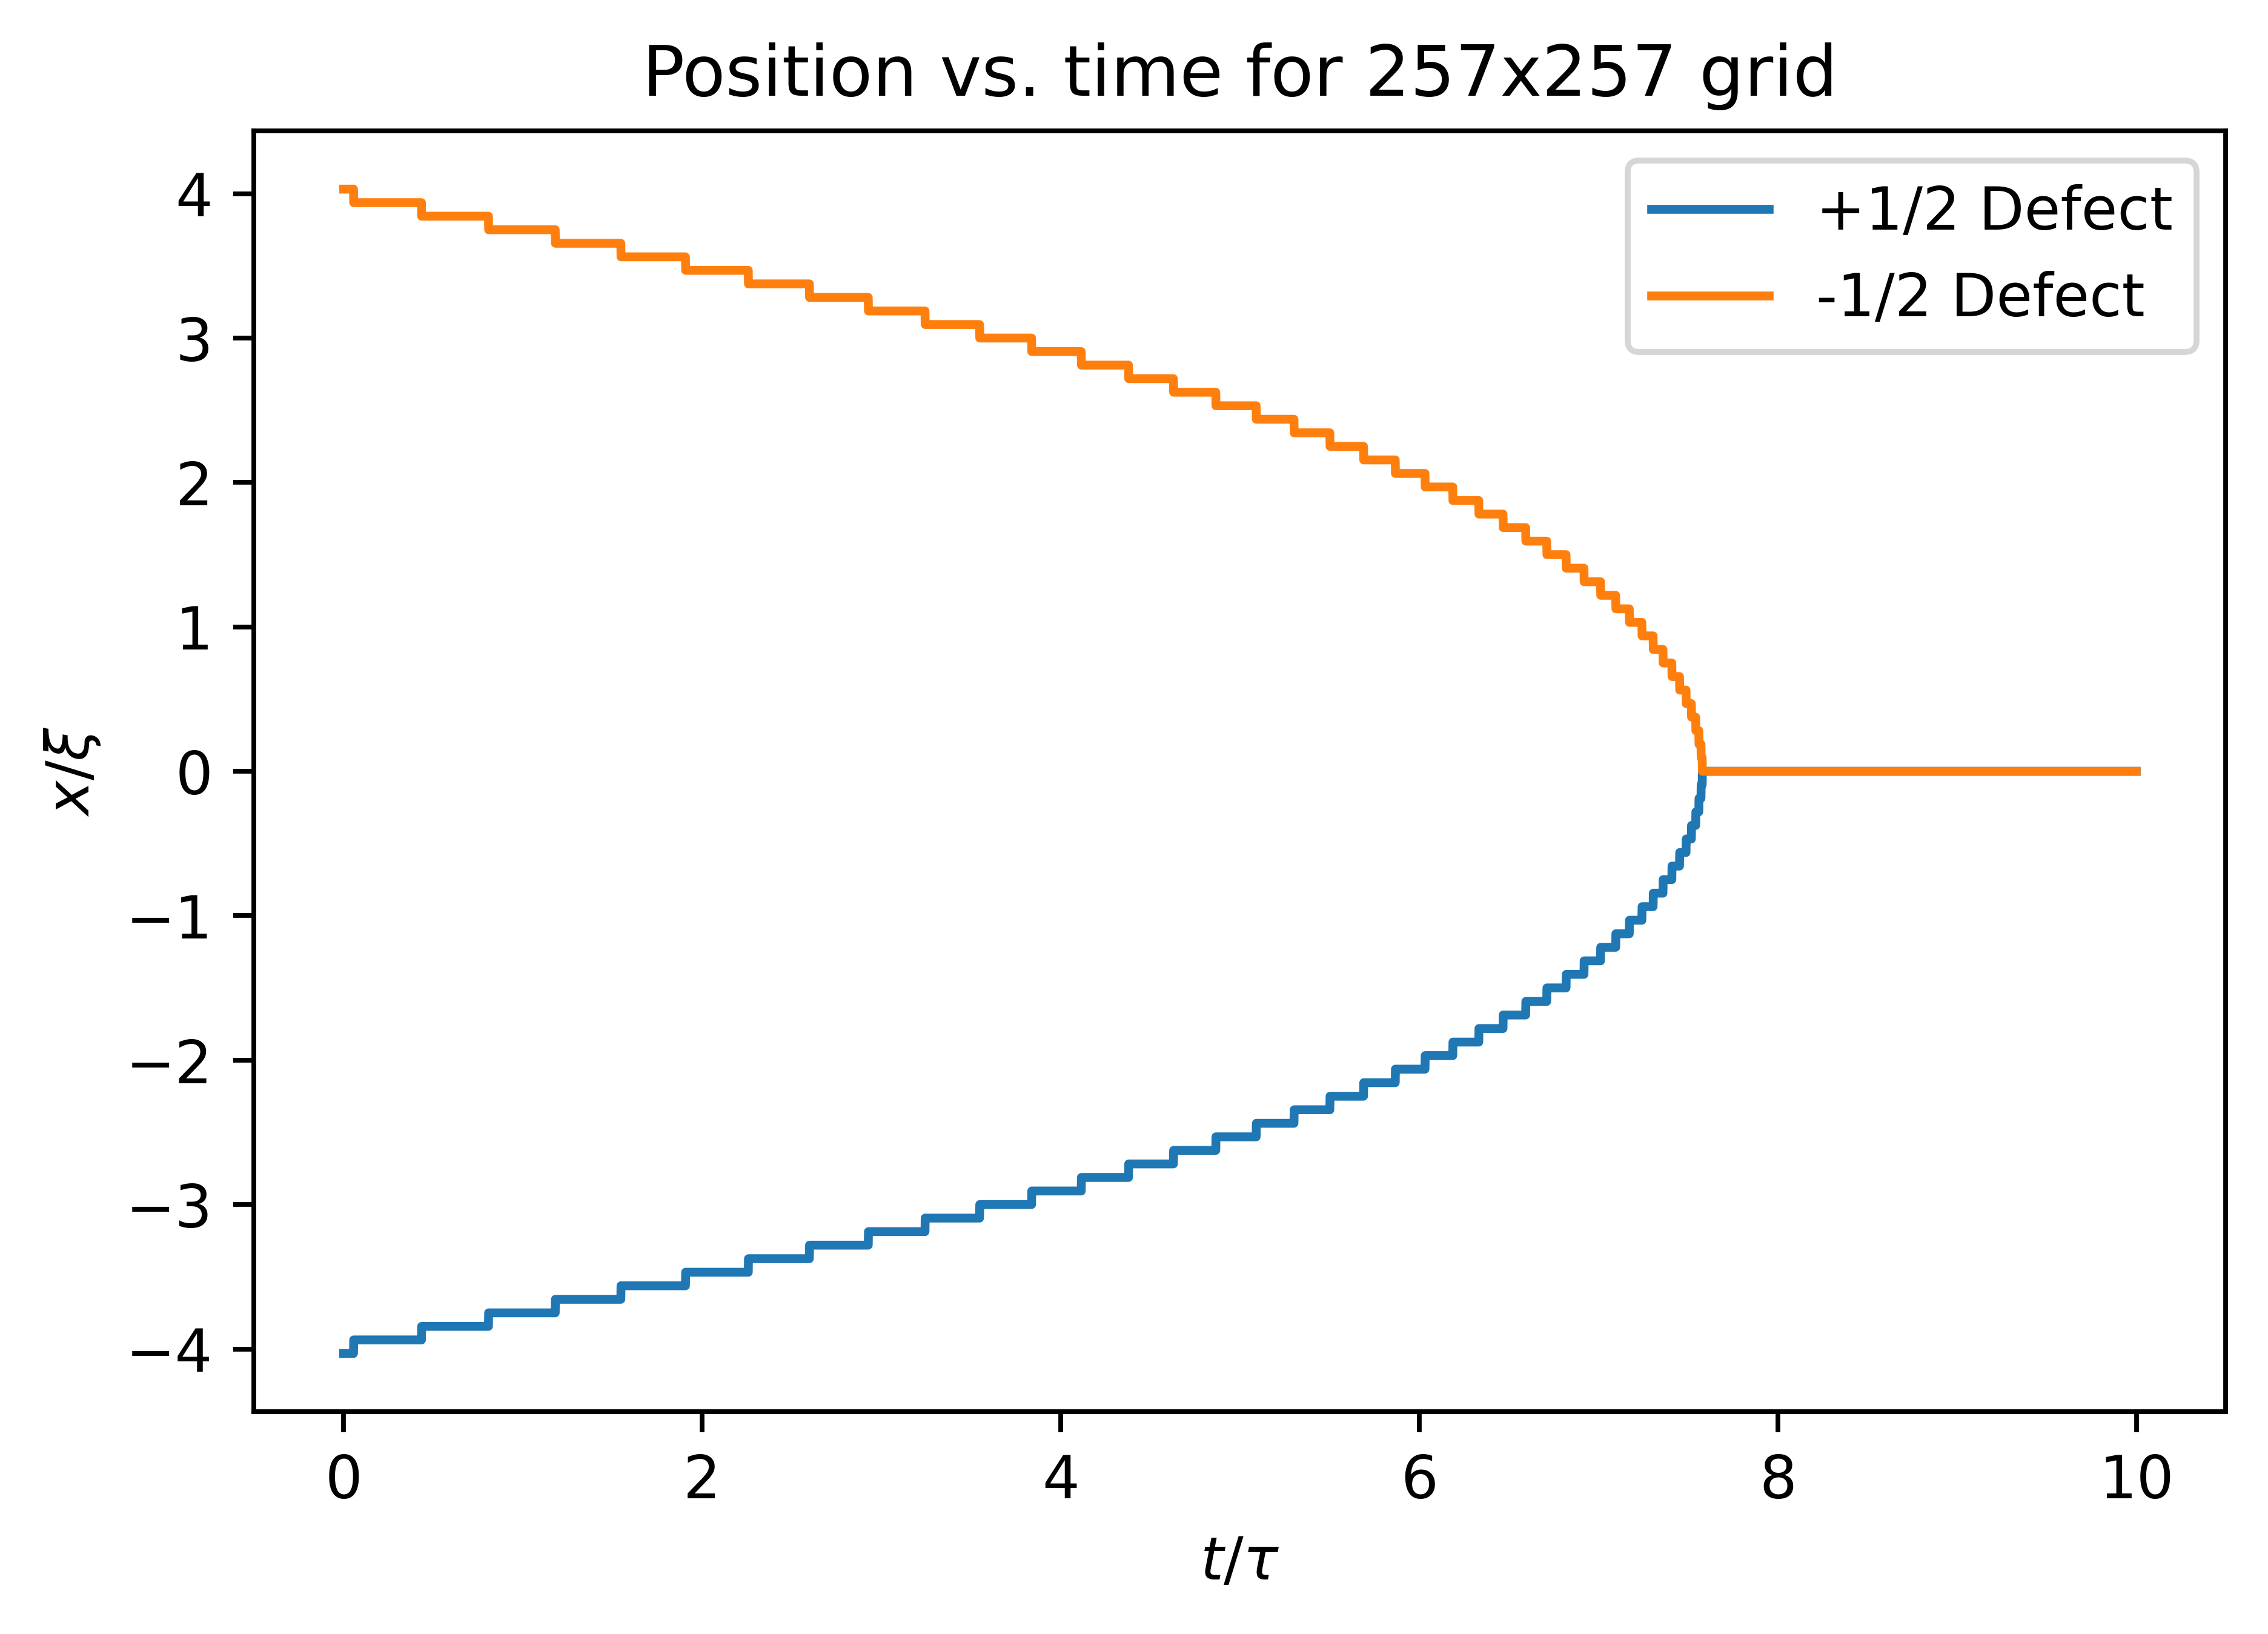

In [8]:
plt.plot(t[:], peak_pos[0, :], label='+1/2 Defect')
plt.plot(t[:], peak_pos[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 257x257 grid')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-257pts-2x-spacing.png')
plt.savefig(filename_defect_pos_vs_time)

### Fit to square root function

In [9]:
def f(x, a, b, c):
    return a*(x - b)**2 + c

C:\Users\lucas\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


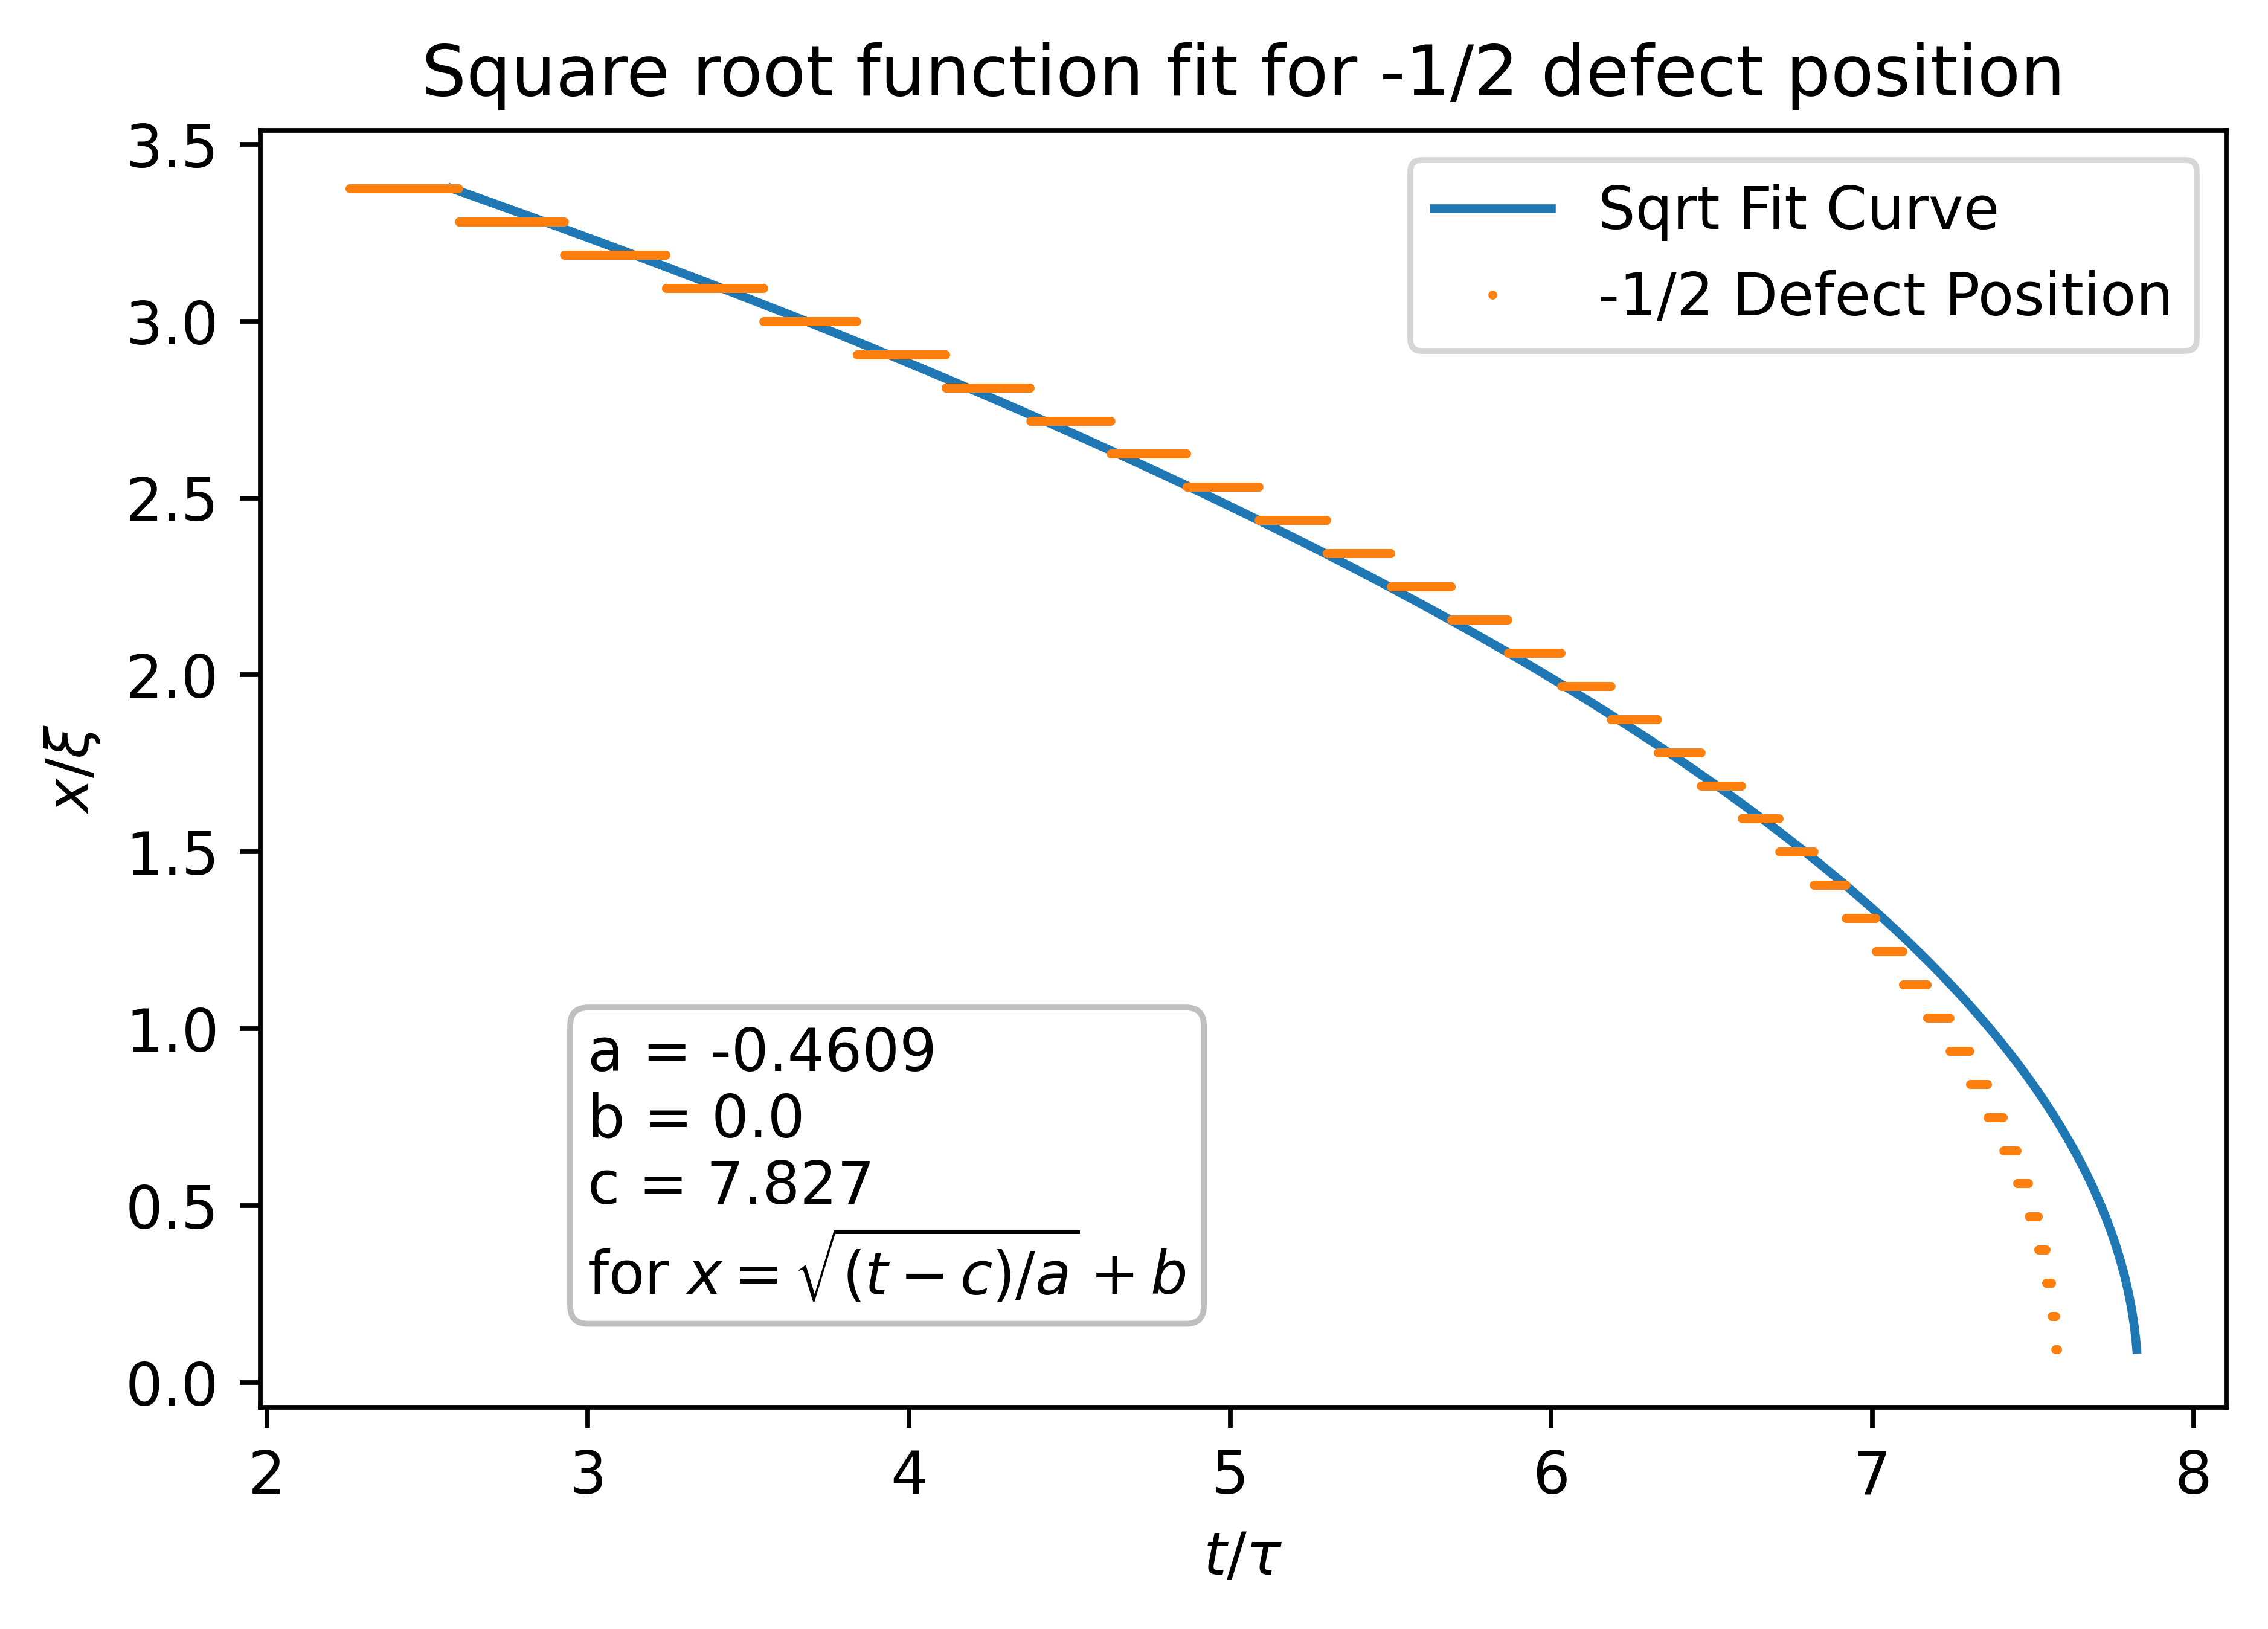

In [10]:
n_gridpoint_truncate = 6

# Truncate after defects meet, reflect over t-axis
defect_not_positive_idx = np.where(peak_pos[1, :] <= 0)[0]
first_not_positive_idx = defect_not_positive_idx[0]
trunc_pos = peak_pos[1, :first_not_positive_idx]
trunc_t = t[:first_not_positive_idx]

# lop off after n_gridpoint_truncate drop
start_idx = np.where(np.diff(trunc_pos))[0][n_gridpoint_truncate] + 1
trunc_pos = trunc_pos[start_idx:]
trunc_t = trunc_t[start_idx:]

trunc_pos_ref = np.hstack((trunc_pos, -trunc_pos[::-1]))
trunc_t_ref = np.hstack((trunc_t, trunc_t[::-1]))

# Find fit params
popt2x, pcov = curve_fit(f, trunc_pos_ref, trunc_t_ref)
a = popt2x[0]
b = popt2x[1]
c = popt2x[2]

# Plot results
fit_pos = np.linspace(trunc_pos[0], trunc_pos[-1], num=1000)
fit_t = f(fit_pos, a, b, c)
plot_text = ( "a = " + str(round(a, 4)) + "\n"
              + "b = " + str(round(b, 4)) + "\n"
              + "c = " + str(round(c, 4)) + "\n"
              + r"for $x = \sqrt{(t - c)/a} + b$" )

fig, ax = plt.subplots()
ax.plot(fit_t, fit_pos, label='Sqrt Fit Curve')
ax.plot(trunc_t, trunc_pos, marker='o', ls='', ms=.5, label='-1/2 Defect Position')
ax.text(3, 0.25, plot_text,
        bbox=dict(boxstyle="round",
                  fc=(1, 1, 1),
                  ec=(.75, .75, .75)))
ax.legend()

ax.set_title('Square root function fit for -1/2 defect position')
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel(r'$x/\xi$')

filename_sqrt_fit = os.path.join(save_folder, r'sqrt-fit-257pts-2x-spacing.png')
fig.savefig(filename_sqrt_fit)

## Same thing, except now make it 4x as big

In [11]:
a = -0.4166
alpha = 0.25*3.1e-4

l = 24
n = 257

S_val = 0.5
ctr = [[-8, 0], [8, 0]]
r = [1, 1]
m = [-1/2, 1/2]

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = np.ceil(-a*ctr[1][0]**2/dt * 2).astype(np.int)
comp_time = alpha*num_steps

print(comp_time)

0.9404625


In [12]:
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= 2:
        peak_pos[:, i] = X[peaks]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=12135)

Simulation ran in 0.6629140966666667 minutes.


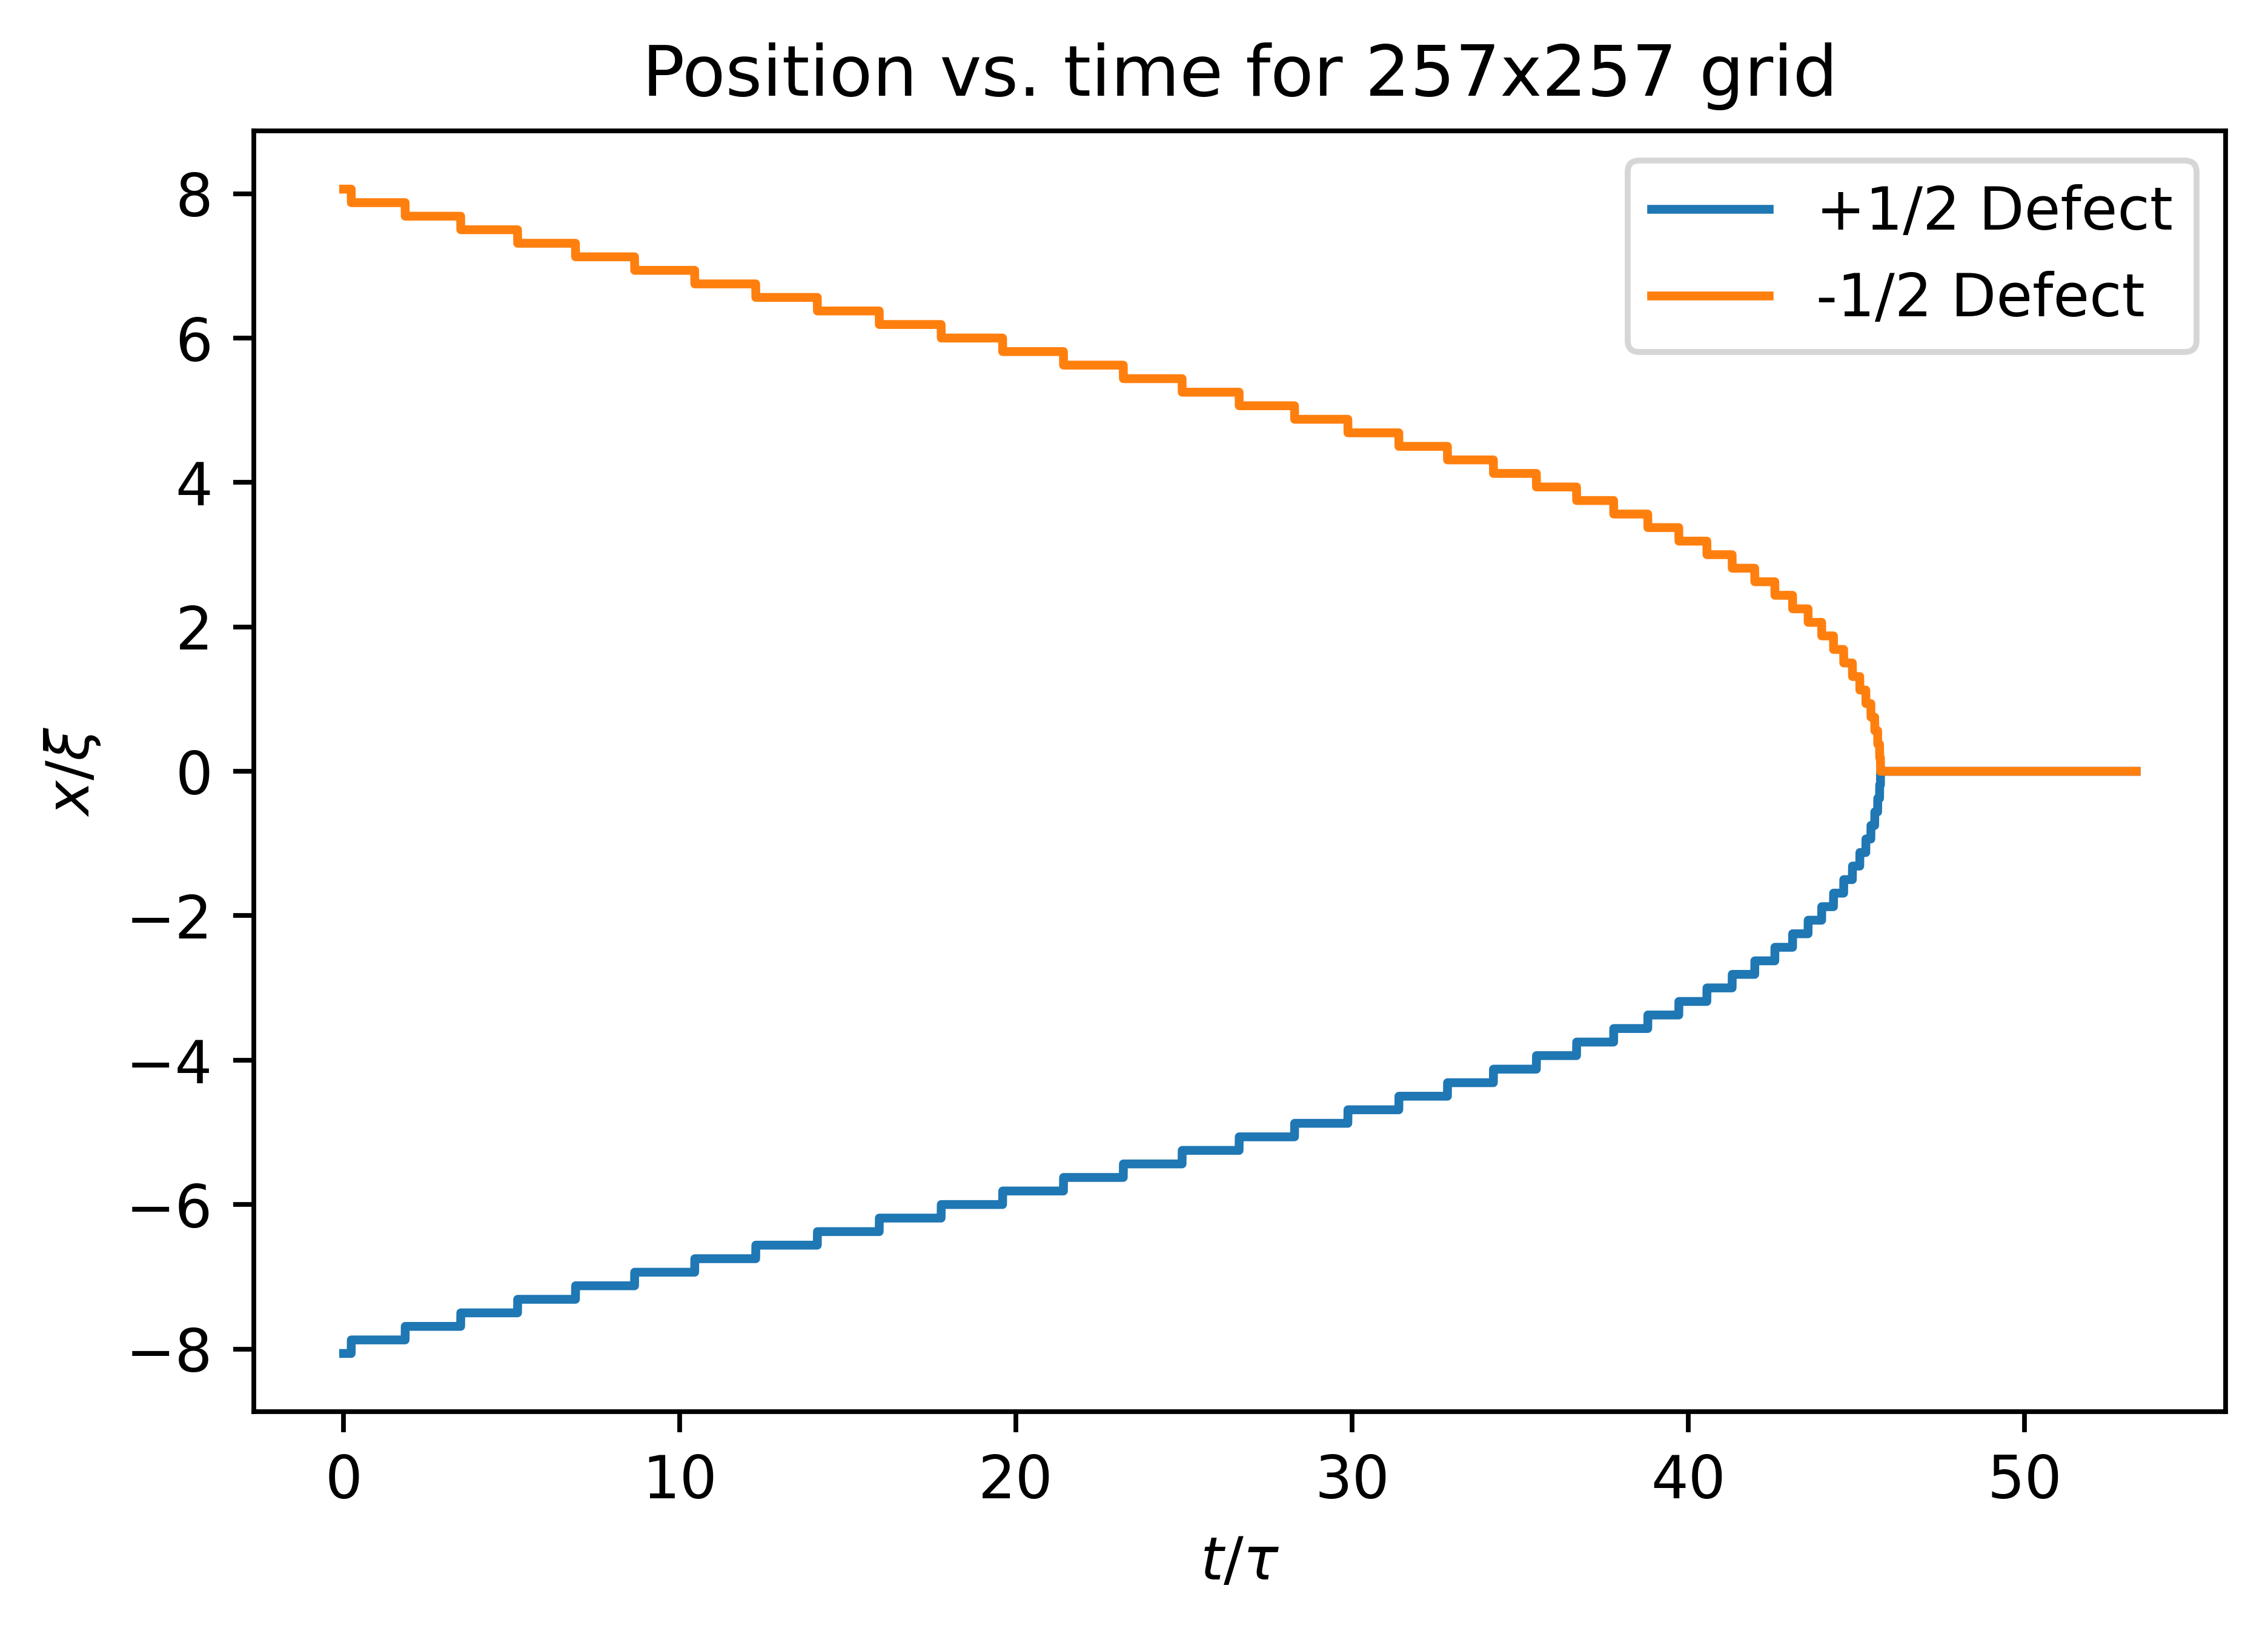

In [13]:
plt.plot(t[:], peak_pos[0, :], label='+1/2 Defect')
plt.plot(t[:], peak_pos[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 257x257 grid')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-257pts-4x-spacing.png')
plt.savefig(filename_defect_pos_vs_time)

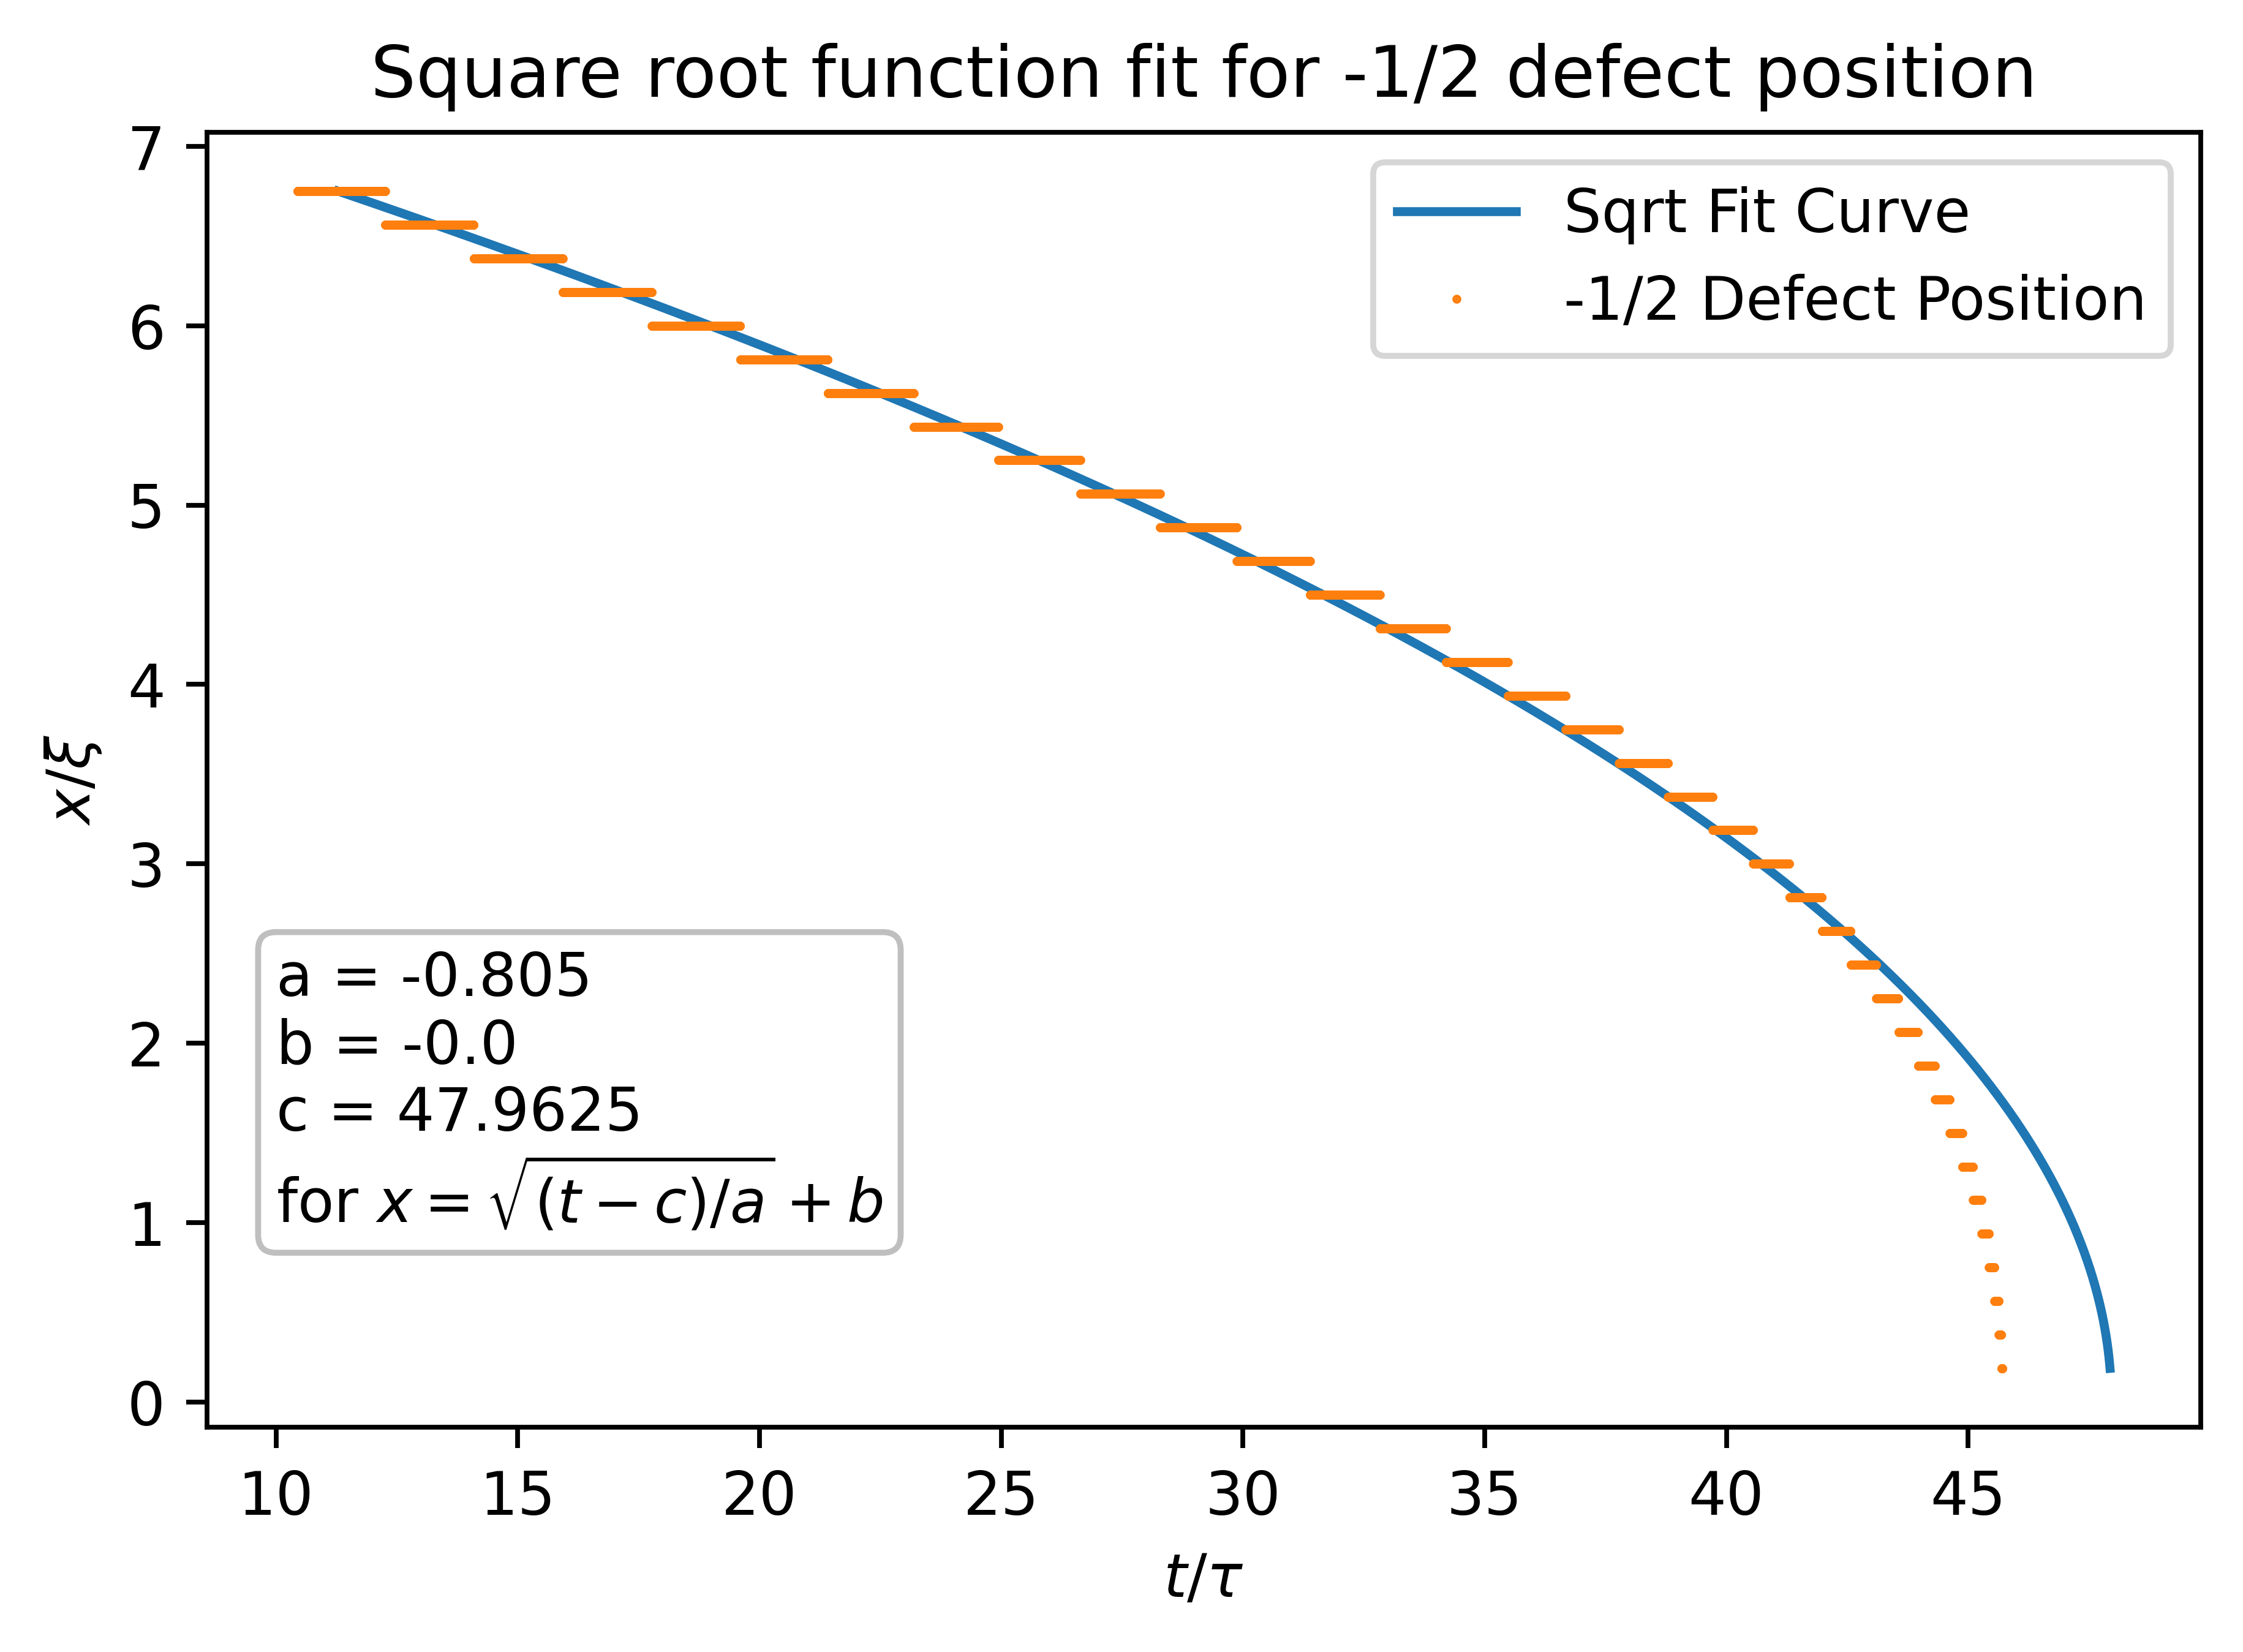

In [14]:
n_gridpoint_truncate = 6

# Truncate after defects meet, reflect over t-axis
defect_not_positive_idx = np.where(peak_pos[1, :] <= 0)[0]
first_not_positive_idx = defect_not_positive_idx[0]
trunc_pos = peak_pos[1, :first_not_positive_idx]
trunc_t = t[:first_not_positive_idx]

# lop off after n_gridpoint_truncate drop
start_idx = np.where(np.diff(trunc_pos))[0][n_gridpoint_truncate] + 1
trunc_pos = trunc_pos[start_idx:]
trunc_t = trunc_t[start_idx:]

trunc_pos_ref = np.hstack((trunc_pos, -trunc_pos[::-1]))
trunc_t_ref = np.hstack((trunc_t, trunc_t[::-1]))

# Find fit params
popt4x, pcov = curve_fit(f, trunc_pos_ref, trunc_t_ref)
a = popt4x[0]
b = popt4x[1]
c = popt4x[2]

# Plot results
fit_pos = np.linspace(trunc_pos[0], trunc_pos[-1], num=1000)
fit_t = f(fit_pos, a, b, c)
plot_text = ( "a = " + str(round(a, 4)) + "\n"
              + "b = " + str(round(b, 4)) + "\n"
              + "c = " + str(round(c, 4)) + "\n"
              + r"for $x = \sqrt{(t - c)/a} + b$" )

fig, ax = plt.subplots()
ax.plot(fit_t, fit_pos, label='Sqrt Fit Curve')
ax.plot(trunc_t, trunc_pos, marker='o', ls='', ms=.5, label='-1/2 Defect Position')
ax.text(10, 1, plot_text,
        bbox=dict(boxstyle="round",
                  fc=(1, 1, 1),
                  ec=(.75, .75, .75)))
ax.legend()

ax.set_title('Square root function fit for -1/2 defect position')
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel(r'$x/\xi$')

filename_sqrt_fit = os.path.join(save_folder, r'sqrt-fit-257pts-4x-spacing.png')
fig.savefig(filename_sqrt_fit)

## Now 16x as big

In [15]:
a = -0.4166
alpha = 0.25*3.1e-4

l = 96
n = 257

S_val = 0.5
ctr = [[-32, 0], [32, 0]]
r = [1, 1]
m = [-1/2, 1/2]

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = np.ceil(-a*ctr[1][0]**2/dt * 4).astype(np.int)
comp_time = alpha*num_steps

print(comp_time)

1.8808475


In [16]:
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= 2:
        peak_pos[:, i] = X[peaks]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=24269)

Simulation ran in 1.3936658566666664 minutes.


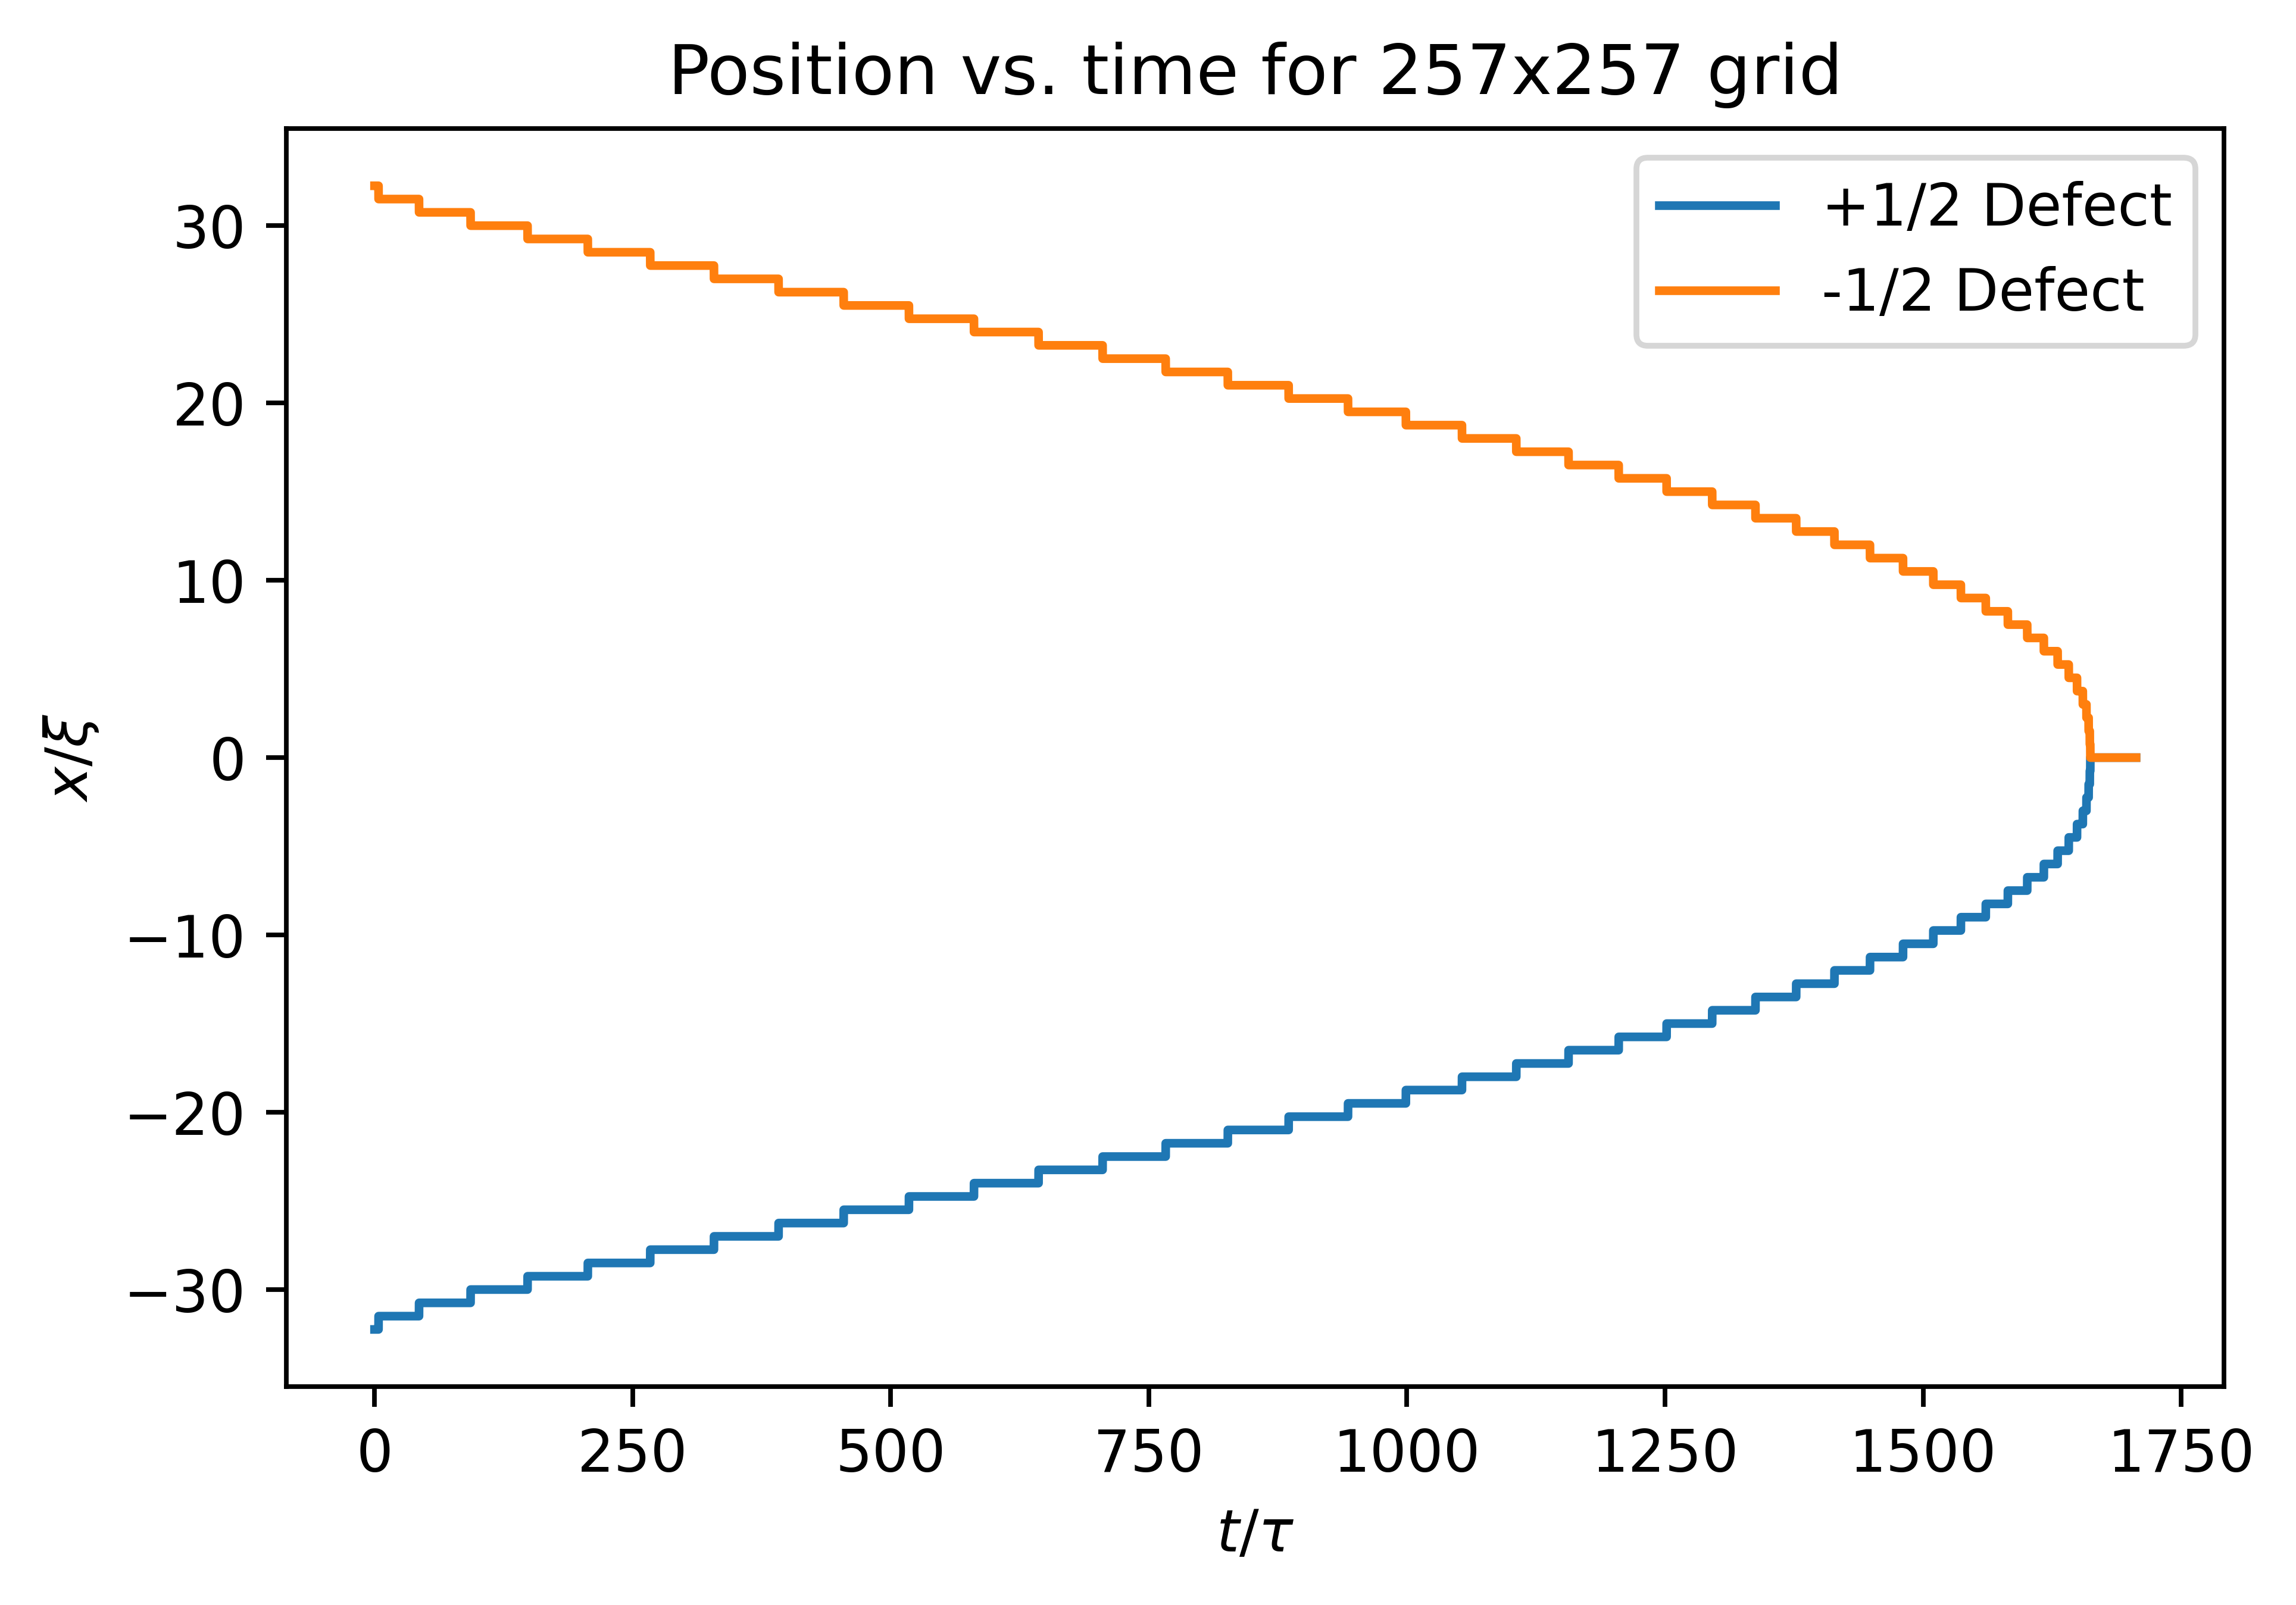

In [17]:
plt.plot(t[:], peak_pos[0, :], label='+1/2 Defect')
plt.plot(t[:], peak_pos[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 257x257 grid')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-257pts-16x-spacing.png')
plt.savefig(filename_defect_pos_vs_time)

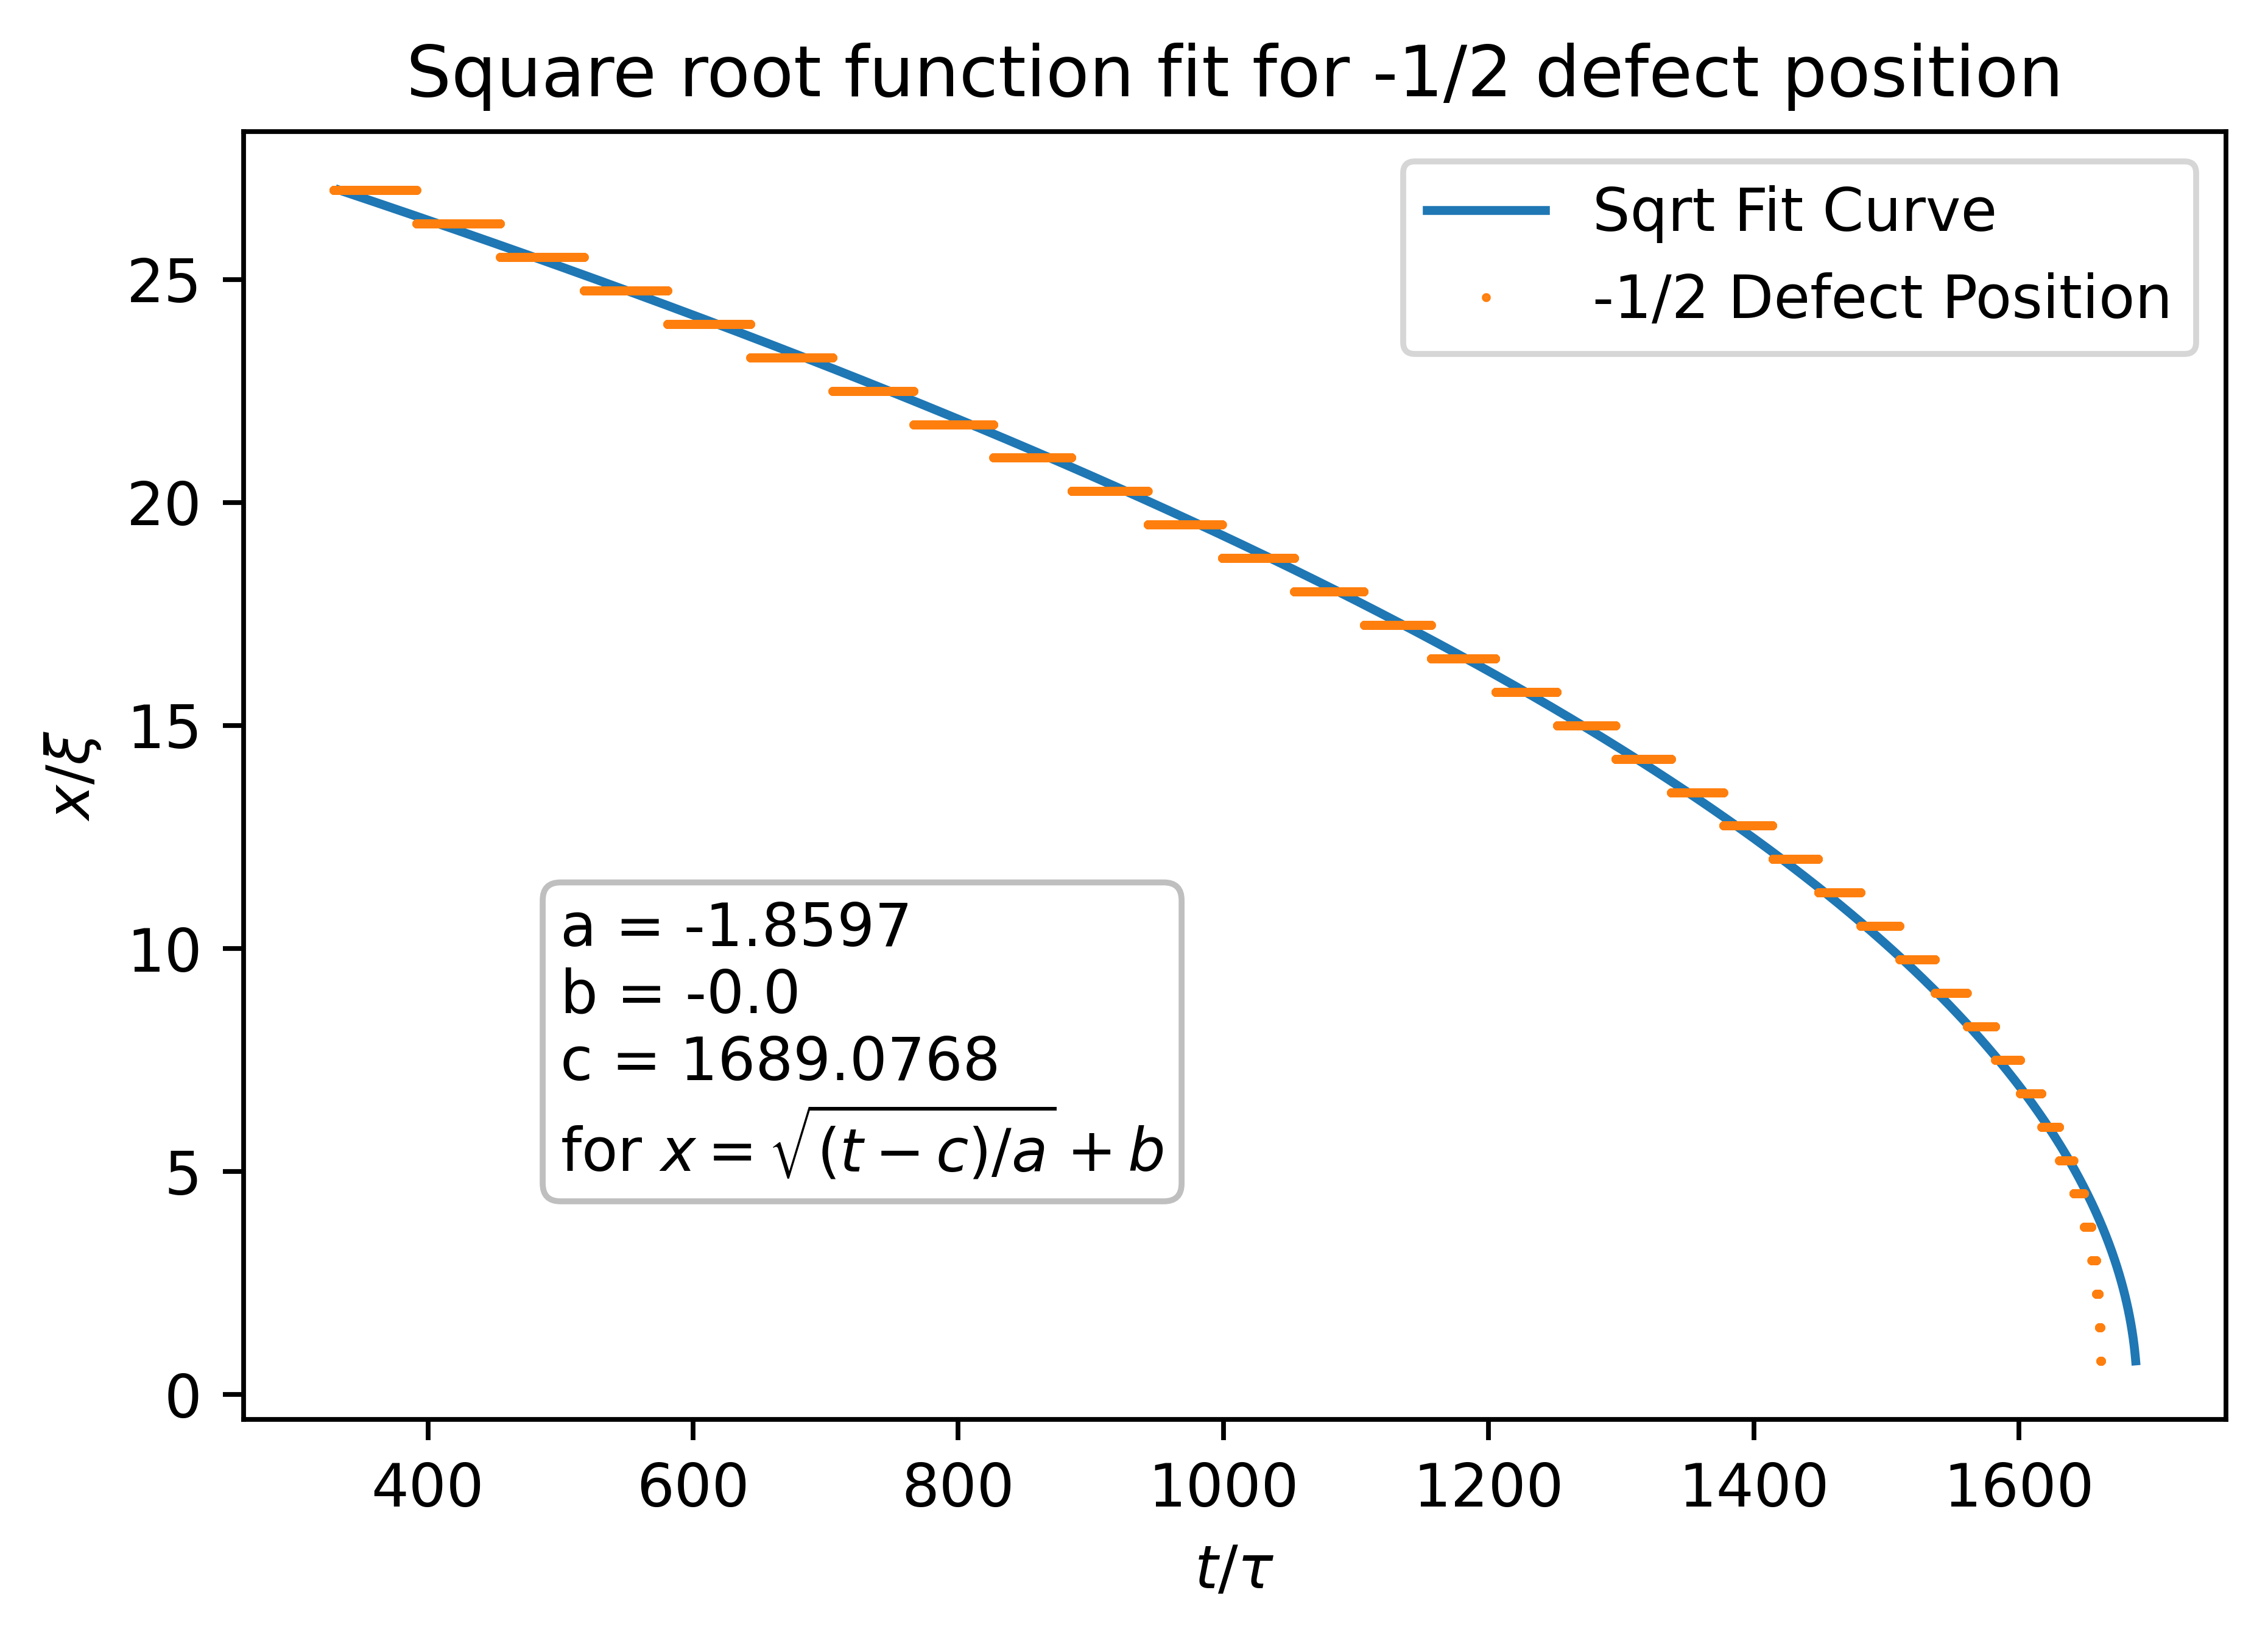

In [18]:
n_gridpoint_truncate = 6

# Truncate after defects meet, reflect over t-axis
defect_not_positive_idx = np.where(peak_pos[1, :] <= 0)[0]
first_not_positive_idx = defect_not_positive_idx[0]
trunc_pos = peak_pos[1, :first_not_positive_idx]
trunc_t = t[:first_not_positive_idx]

# lop off after n_gridpoint_truncate drop
start_idx = np.where(np.diff(trunc_pos))[0][n_gridpoint_truncate] + 1
trunc_pos = trunc_pos[start_idx:]
trunc_t = trunc_t[start_idx:]

trunc_pos_ref = np.hstack((trunc_pos, -trunc_pos[::-1]))
trunc_t_ref = np.hstack((trunc_t, trunc_t[::-1]))

# Find fit params
popt16x, pcov = curve_fit(f, trunc_pos_ref, trunc_t_ref)
a = popt16x[0]
b = popt16x[1]
c = popt16x[2]

# Plot results
fit_pos = np.linspace(trunc_pos[0], trunc_pos[-1], num=1000)
fit_t = f(fit_pos, a, b, c)
plot_text = ( "a = " + str(round(a, 4)) + "\n"
              + "b = " + str(round(b, 4)) + "\n"
              + "c = " + str(round(c, 4)) + "\n"
              + r"for $x = \sqrt{(t - c)/a} + b$" )

fig, ax = plt.subplots()
ax.plot(fit_t, fit_pos, label='Sqrt Fit Curve')
ax.plot(trunc_t, trunc_pos, marker='o', ls='', ms=.5, label='-1/2 Defect Position')
ax.text(500, 5, plot_text,
        bbox=dict(boxstyle="round",
                  fc=(1, 1, 1),
                  ec=(.75, .75, .75)))
ax.legend()

ax.set_title('Square root function fit for -1/2 defect position')
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel(r'$x/\xi$')

filename_sqrt_fit = os.path.join(save_folder, r'sqrt-fit-257pts-16x-spacing.png')
fig.savefig(filename_sqrt_fit)

## Last one which is 32x as big (similar size to Svensek and Zumer)

In [19]:
a = -0.4166
alpha = 0.25*3.1e-4

l = 96*2
n = 257

S_val = 0.5
ctr = [[-32*2, 0], [32*2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = np.ceil(-a*ctr[1][0]**2/dt * 8).astype(np.int)
comp_time = alpha*num_steps

print(comp_time)

3.761695


In [20]:
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= 2:
        peak_pos[:, i] = X[peaks]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=48538)

Simulation ran in 2.5225221833333333 minutes.


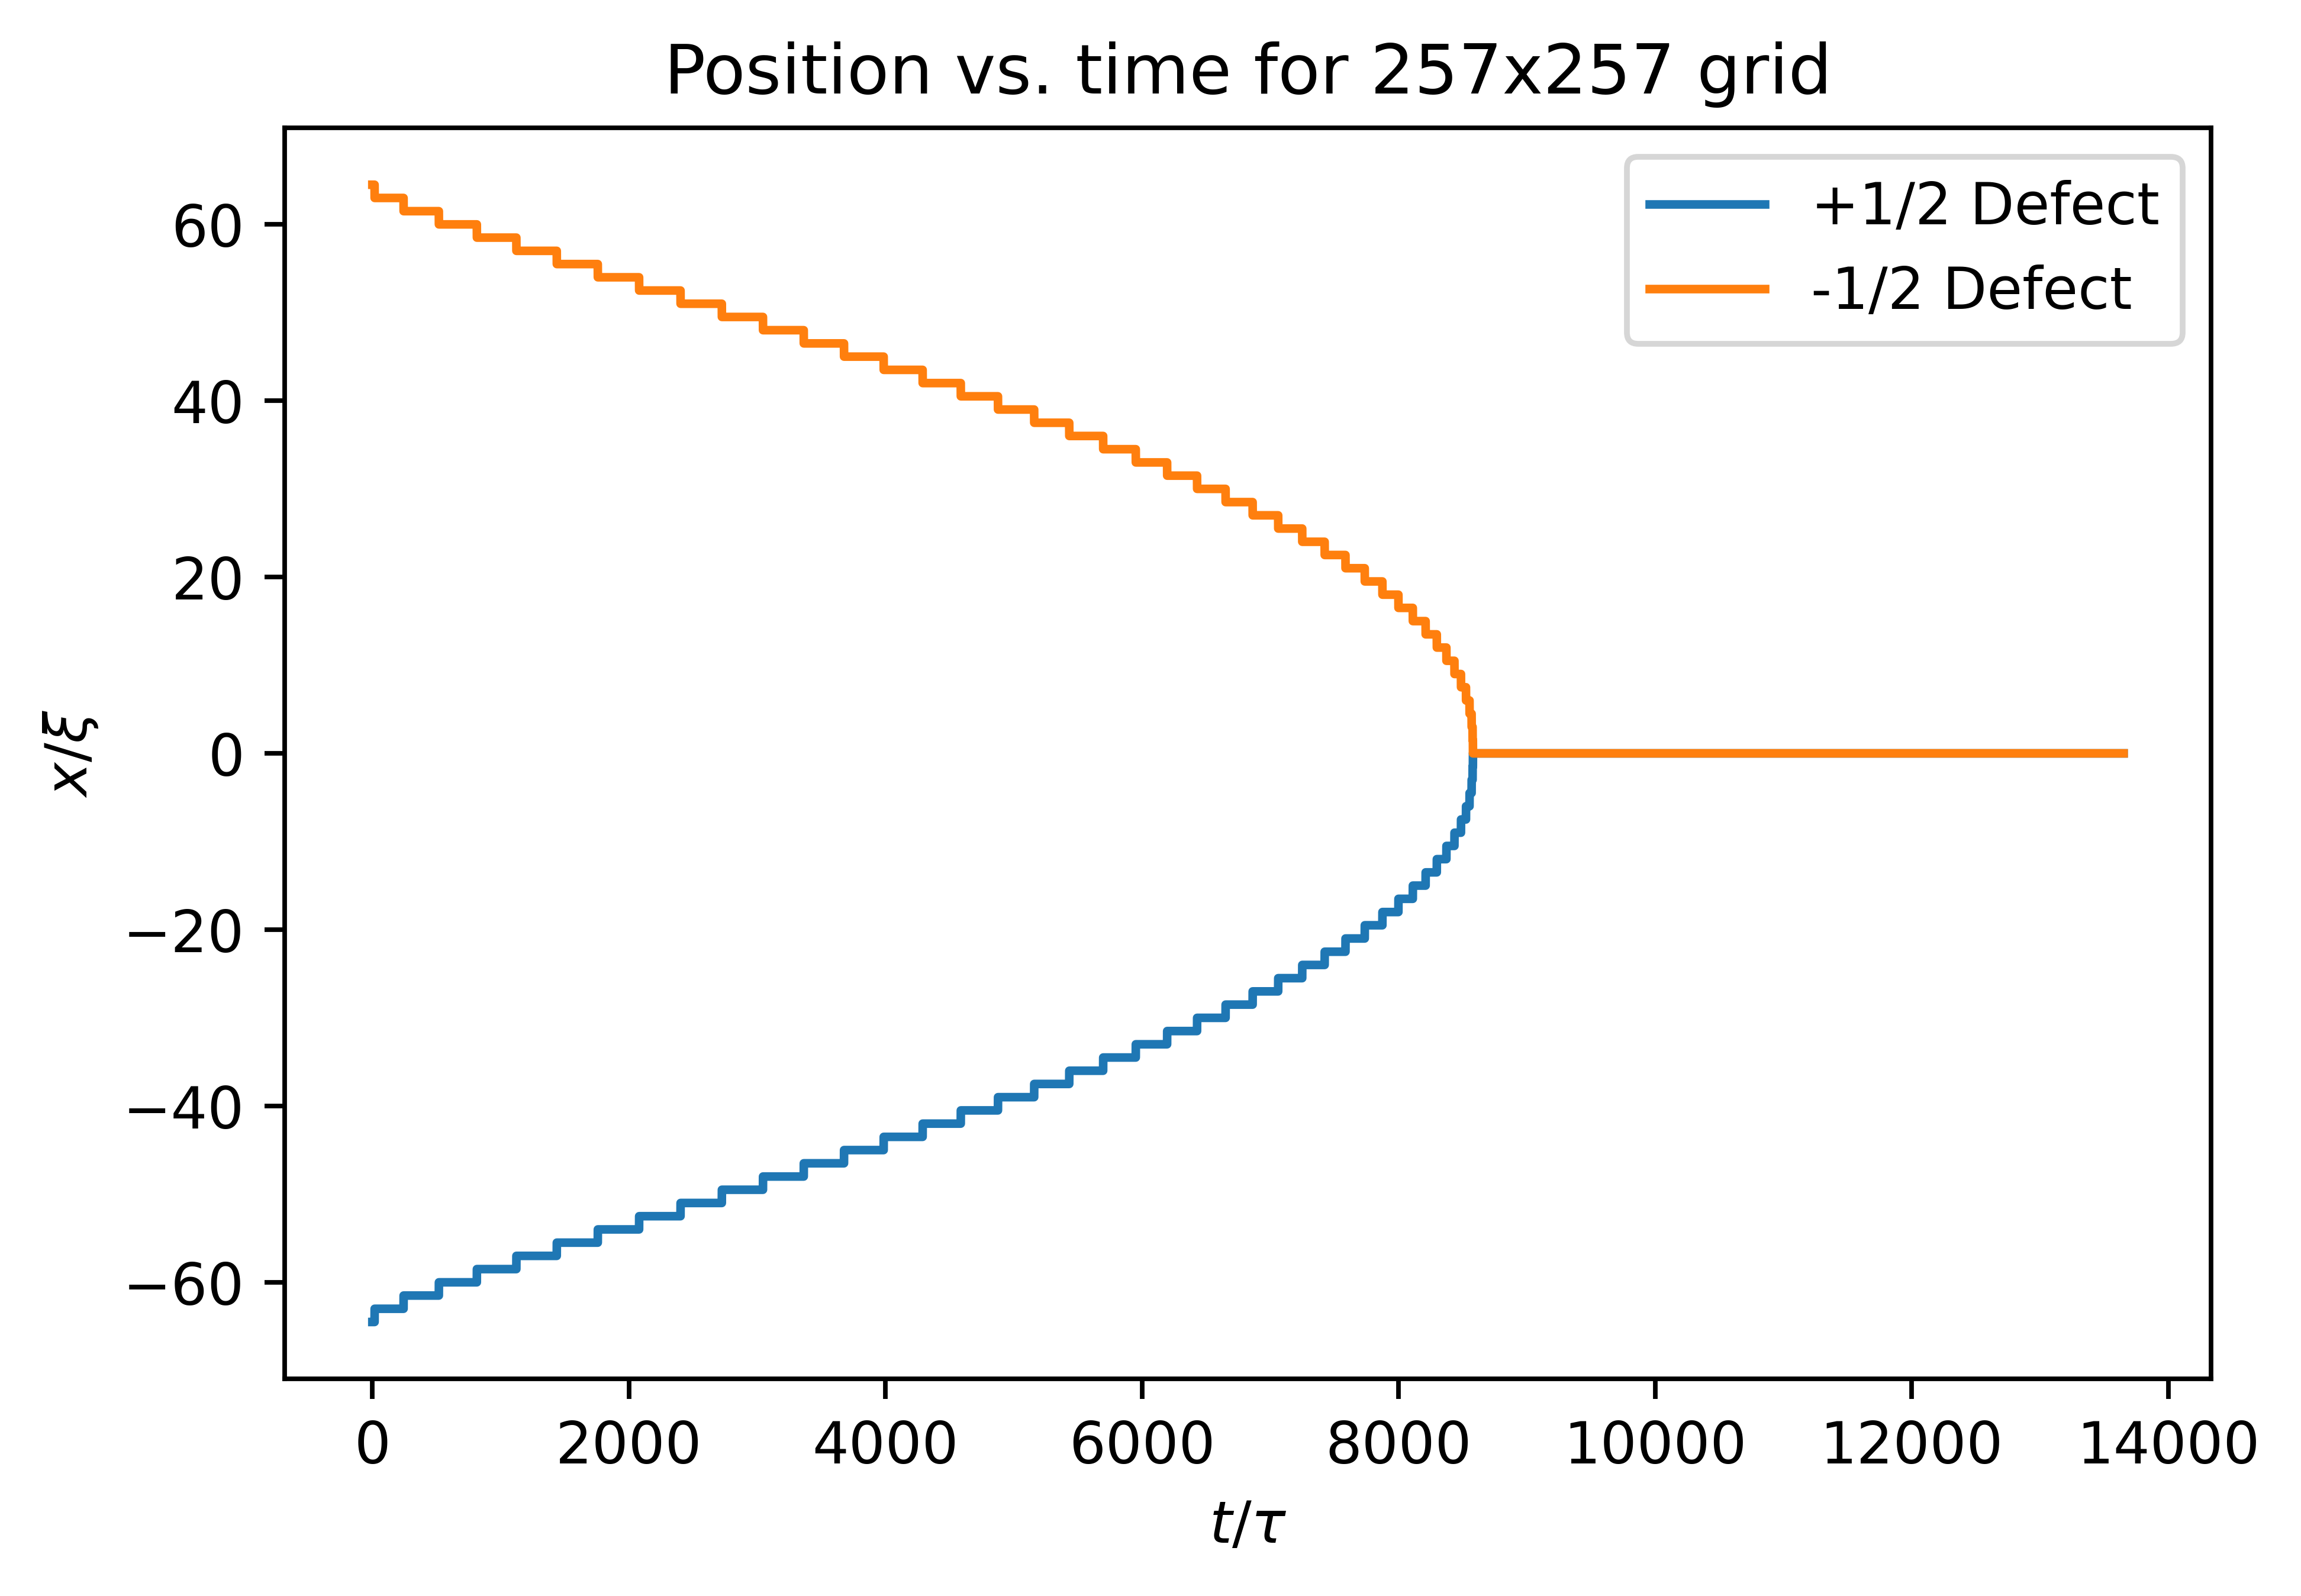

In [21]:
plt.plot(t[:], peak_pos[0, :], label='+1/2 Defect')
plt.plot(t[:], peak_pos[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 257x257 grid')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-257pts-32x-spacing.png')
plt.savefig(filename_defect_pos_vs_time)

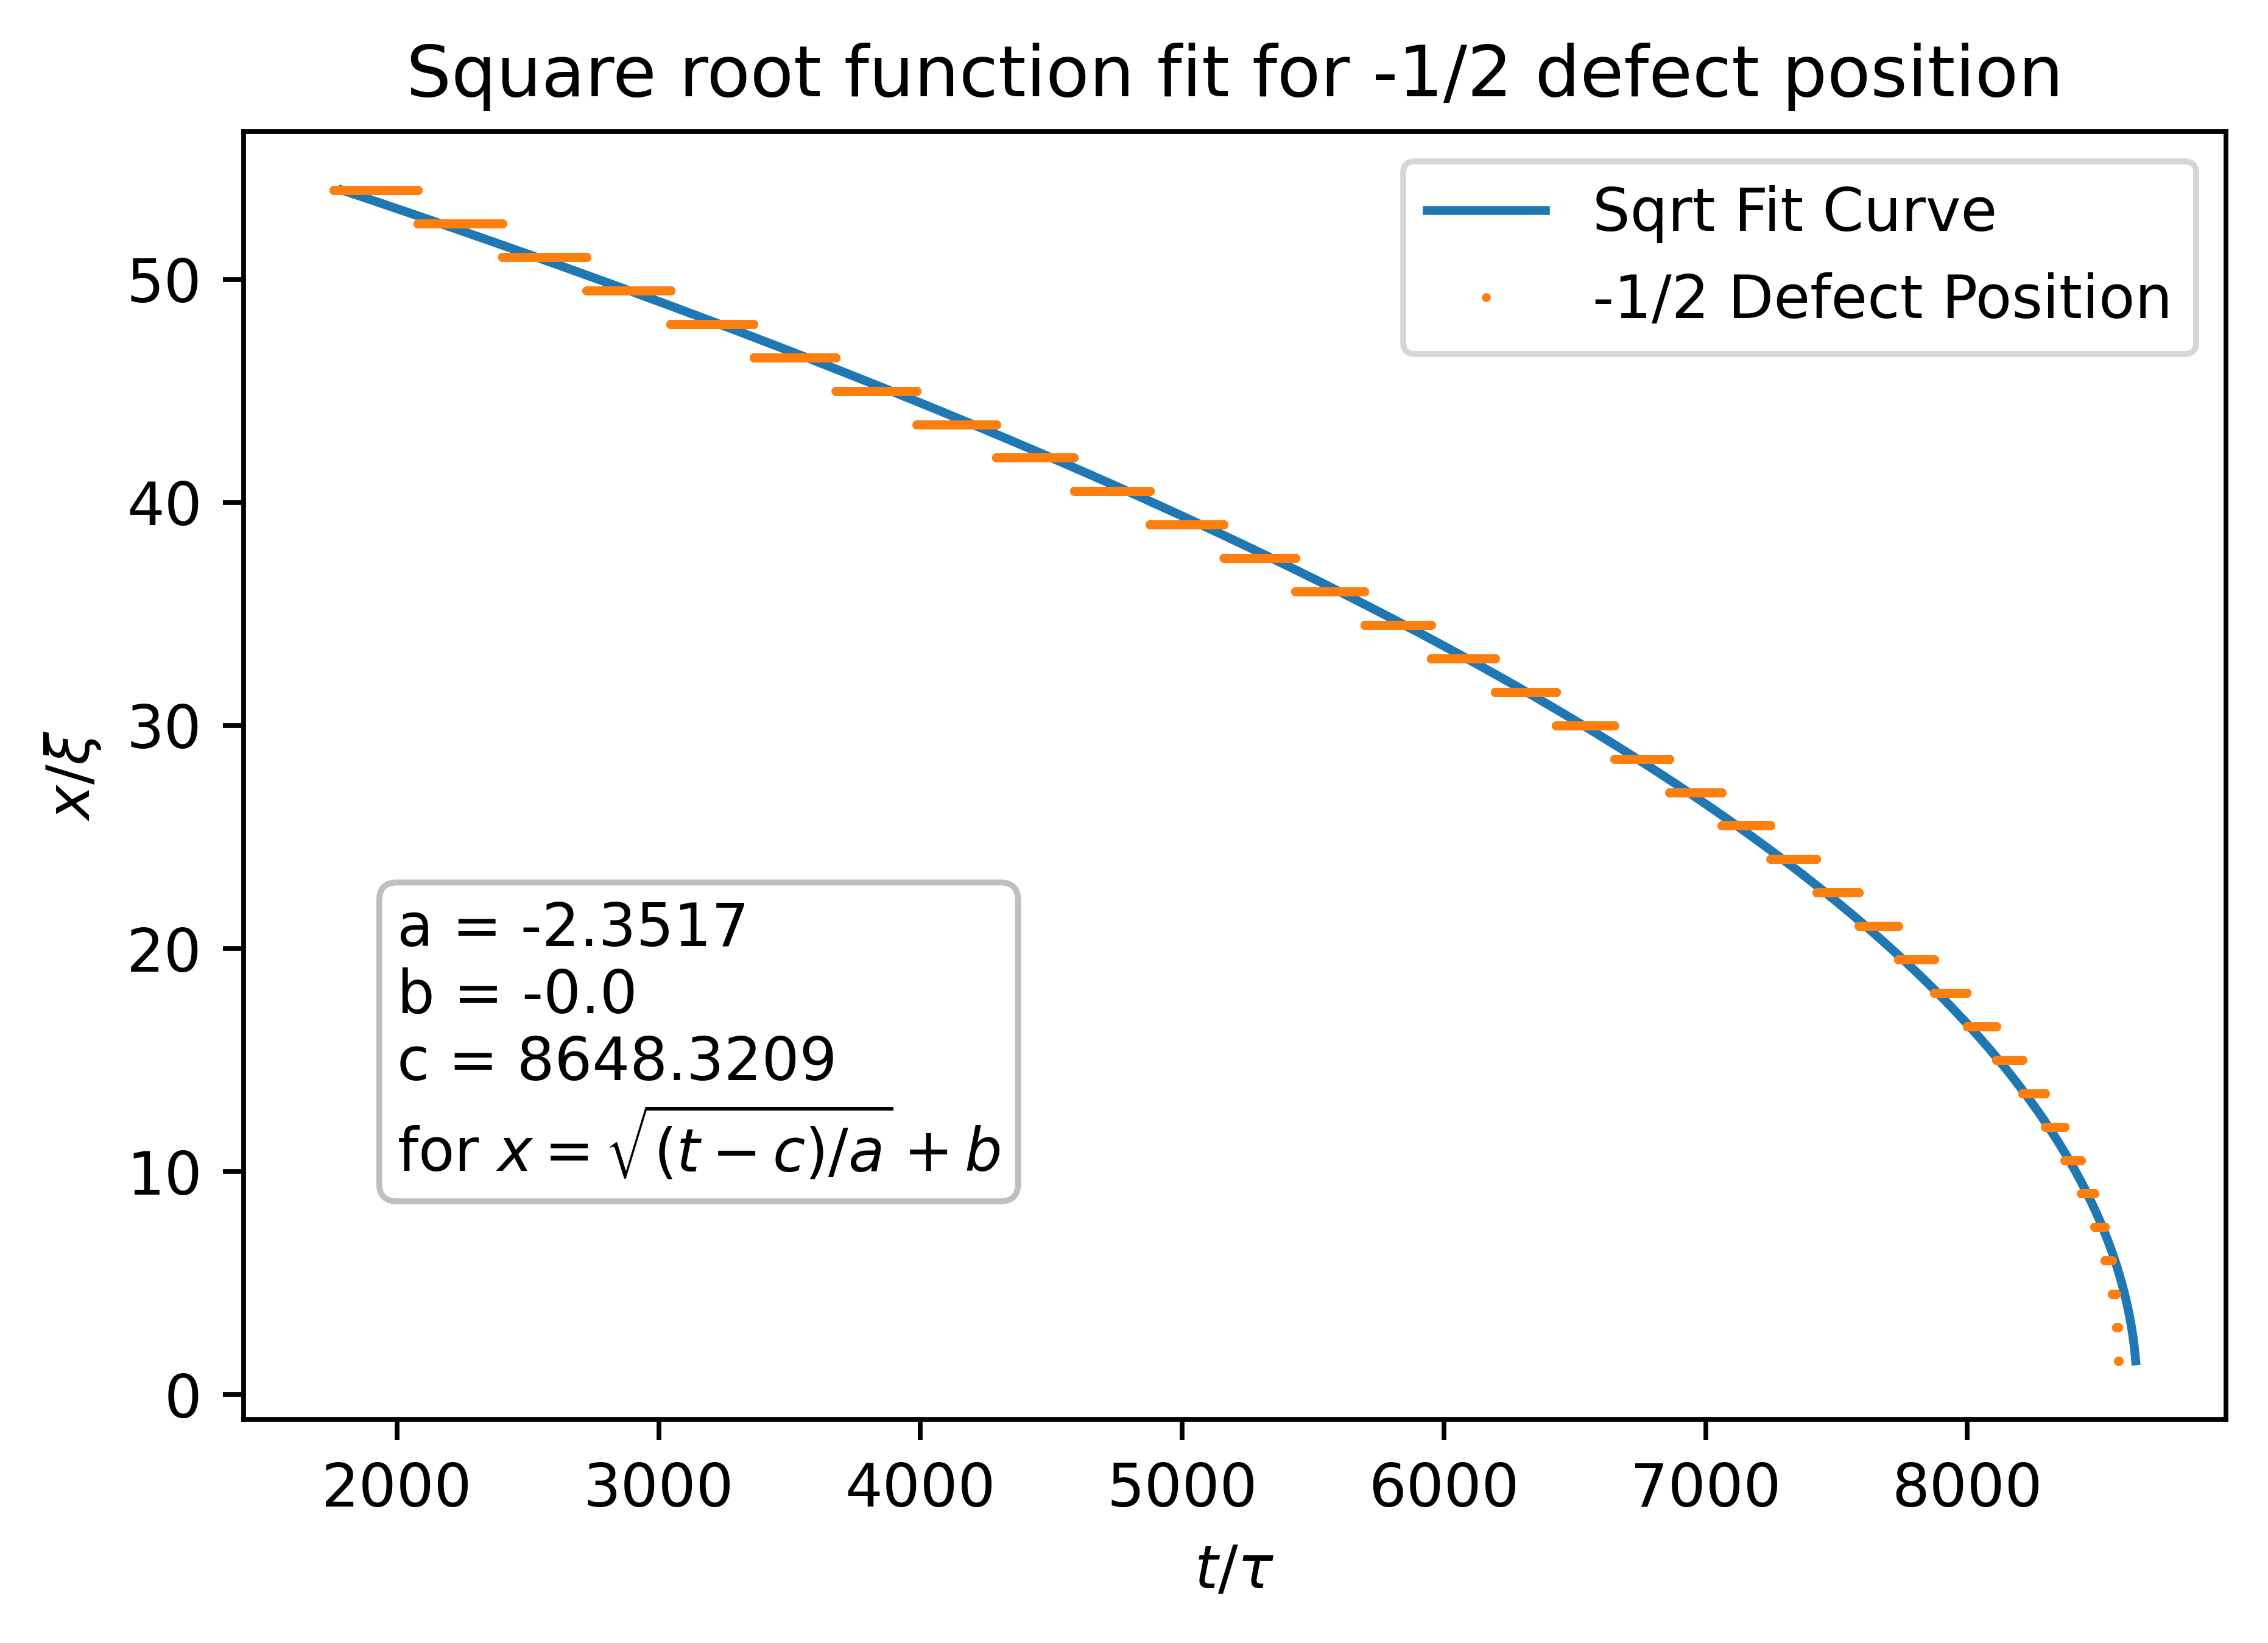

In [22]:
n_gridpoint_truncate = 6

# Truncate after defects meet, reflect over t-axis
defect_not_positive_idx = np.where(peak_pos[1, :] <= 0)[0]
first_not_positive_idx = defect_not_positive_idx[0]
trunc_pos = peak_pos[1, :first_not_positive_idx]
trunc_t = t[:first_not_positive_idx]

# lop off after n_gridpoint_truncate drop
start_idx = np.where(np.diff(trunc_pos))[0][n_gridpoint_truncate] + 1
trunc_pos = trunc_pos[start_idx:]
trunc_t = trunc_t[start_idx:]

trunc_pos_ref = np.hstack((trunc_pos, -trunc_pos[::-1]))
trunc_t_ref = np.hstack((trunc_t, trunc_t[::-1]))

# Find fit params
popt32x, pcov = curve_fit(f, trunc_pos_ref, trunc_t_ref)
a = popt32x[0]
b = popt32x[1]
c = popt32x[2]

# Plot results
fit_pos = np.linspace(trunc_pos[0], trunc_pos[-1], num=1000)
fit_t = f(fit_pos, a, b, c)
plot_text = ( "a = " + str(round(a, 4)) + "\n"
              + "b = " + str(round(b, 4)) + "\n"
              + "c = " + str(round(c, 4)) + "\n"
              + r"for $x = \sqrt{(t - c)/a} + b$" )

fig, ax = plt.subplots()
ax.plot(fit_t, fit_pos, label='Sqrt Fit Curve')
ax.plot(trunc_t, trunc_pos, marker='o', ls='', ms=.5, label='-1/2 Defect Position')
ax.text(2000, 10, plot_text,
        bbox=dict(boxstyle="round",
                  fc=(1, 1, 1),
                  ec=(.75, .75, .75)))
ax.legend()

ax.set_title('Square root function fit for -1/2 defect position')
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel(r'$x/\xi$')

filename_sqrt_fit = os.path.join(save_folder, r'sqrt-fit-257pts-32x-spacing.png')
fig.savefig(filename_sqrt_fit)

### Observation: it takes way longer than I expect it to (based on calculations in TwoDefectDisclinationCompiledSimulation.ipynb) for the defects to come together.

### Possible explanations: 
1. The simulation distorts the square root behavior at small starting length scales
2. The square root behavior actually doesn't show up at small length scales (only precisely square root if the defects start out far apart).
3. The square root parameters somehow depend on initial position.

### To test:
1. Going to fit each of these results to square root functions and see how the parameters stack up.
2. Should see if I can find any mention of this in de Gennes

### Still to do:
1. Need to plot each of the a parameters vs. the initial distance.
2. Additionally, it might be worth lopping off that first part to see if it gives a better square root function fit.
    - Probably just truncate a fourth at the beginning or something

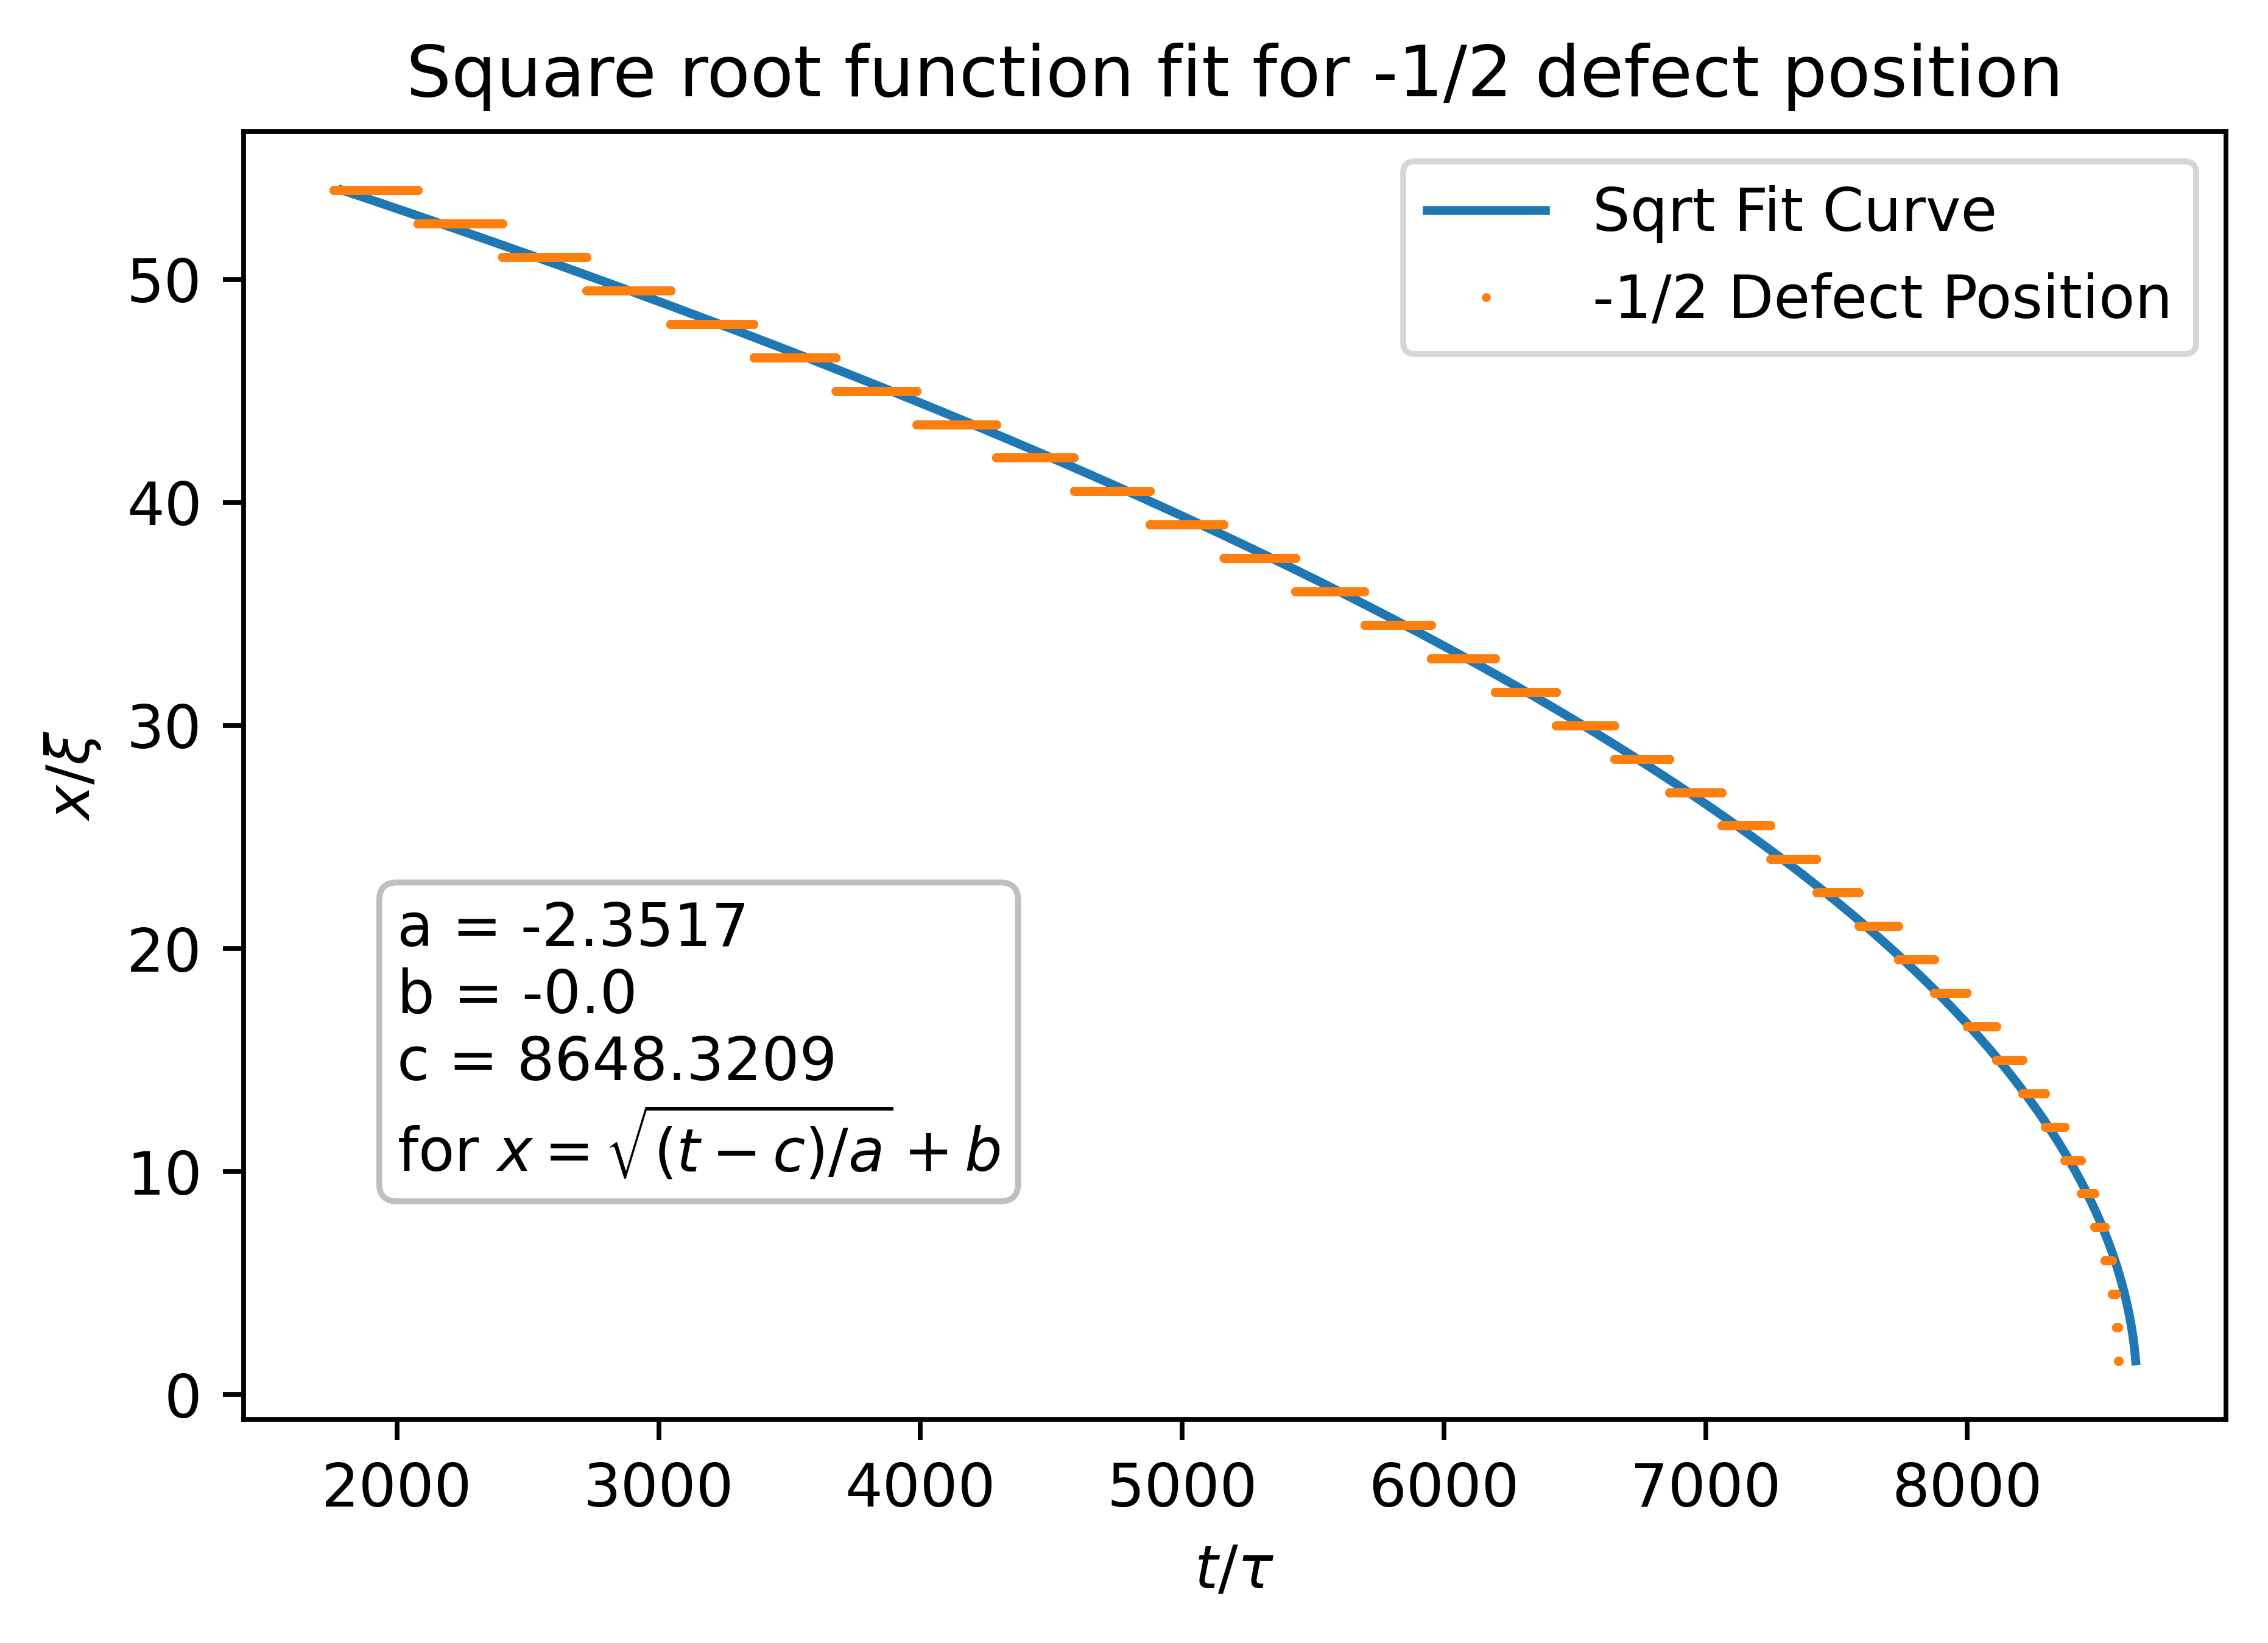

In [23]:
n_gridpoint_truncate = 6

# Truncate after defects meet, reflect over t-axis
defect_not_positive_idx = np.where(peak_pos[1, :] <= 0)[0]
first_not_positive_idx = defect_not_positive_idx[0]
trunc_pos = peak_pos[1, :first_not_positive_idx]
trunc_t = t[:first_not_positive_idx]

# lop off after n_gridpoint_truncate drop
start_idx = np.where(np.diff(trunc_pos))[0][n_gridpoint_truncate] + 1
trunc_pos = trunc_pos[start_idx:]
trunc_t = trunc_t[start_idx:]

trunc_pos_ref = np.hstack((trunc_pos, -trunc_pos[::-1]))
trunc_t_ref = np.hstack((trunc_t, trunc_t[::-1]))

# Find fit params
popt, pcov = curve_fit(f, trunc_pos_ref, trunc_t_ref)
a = popt[0]
b = popt[1]
c = popt[2]

# Plot results
fit_pos = np.linspace(trunc_pos[0], trunc_pos[-1], num=1000)
fit_t = f(fit_pos, a, b, c)
plot_text = ( "a = " + str(round(a, 4)) + "\n"
              + "b = " + str(round(b, 4)) + "\n"
              + "c = " + str(round(c, 4)) + "\n"
              + r"for $x = \sqrt{(t - c)/a} + b$" )

fig, ax = plt.subplots()
ax.plot(fit_t, fit_pos, label='Sqrt Fit Curve')
ax.plot(trunc_t, trunc_pos, marker='o', ls='', ms=.5, label='-1/2 Defect Position')
ax.text(2000, 10, plot_text,
        bbox=dict(boxstyle="round",
                  fc=(1, 1, 1),
                  ec=(.75, .75, .75)))
ax.legend()

ax.set_title('Square root function fit for -1/2 defect position')
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel(r'$x/\xi$')

filename_sqrt_fit = os.path.join(save_folder, r'sqrt-fit-257pts-32x-spacing.png')
fig.savefig(filename_sqrt_fit)

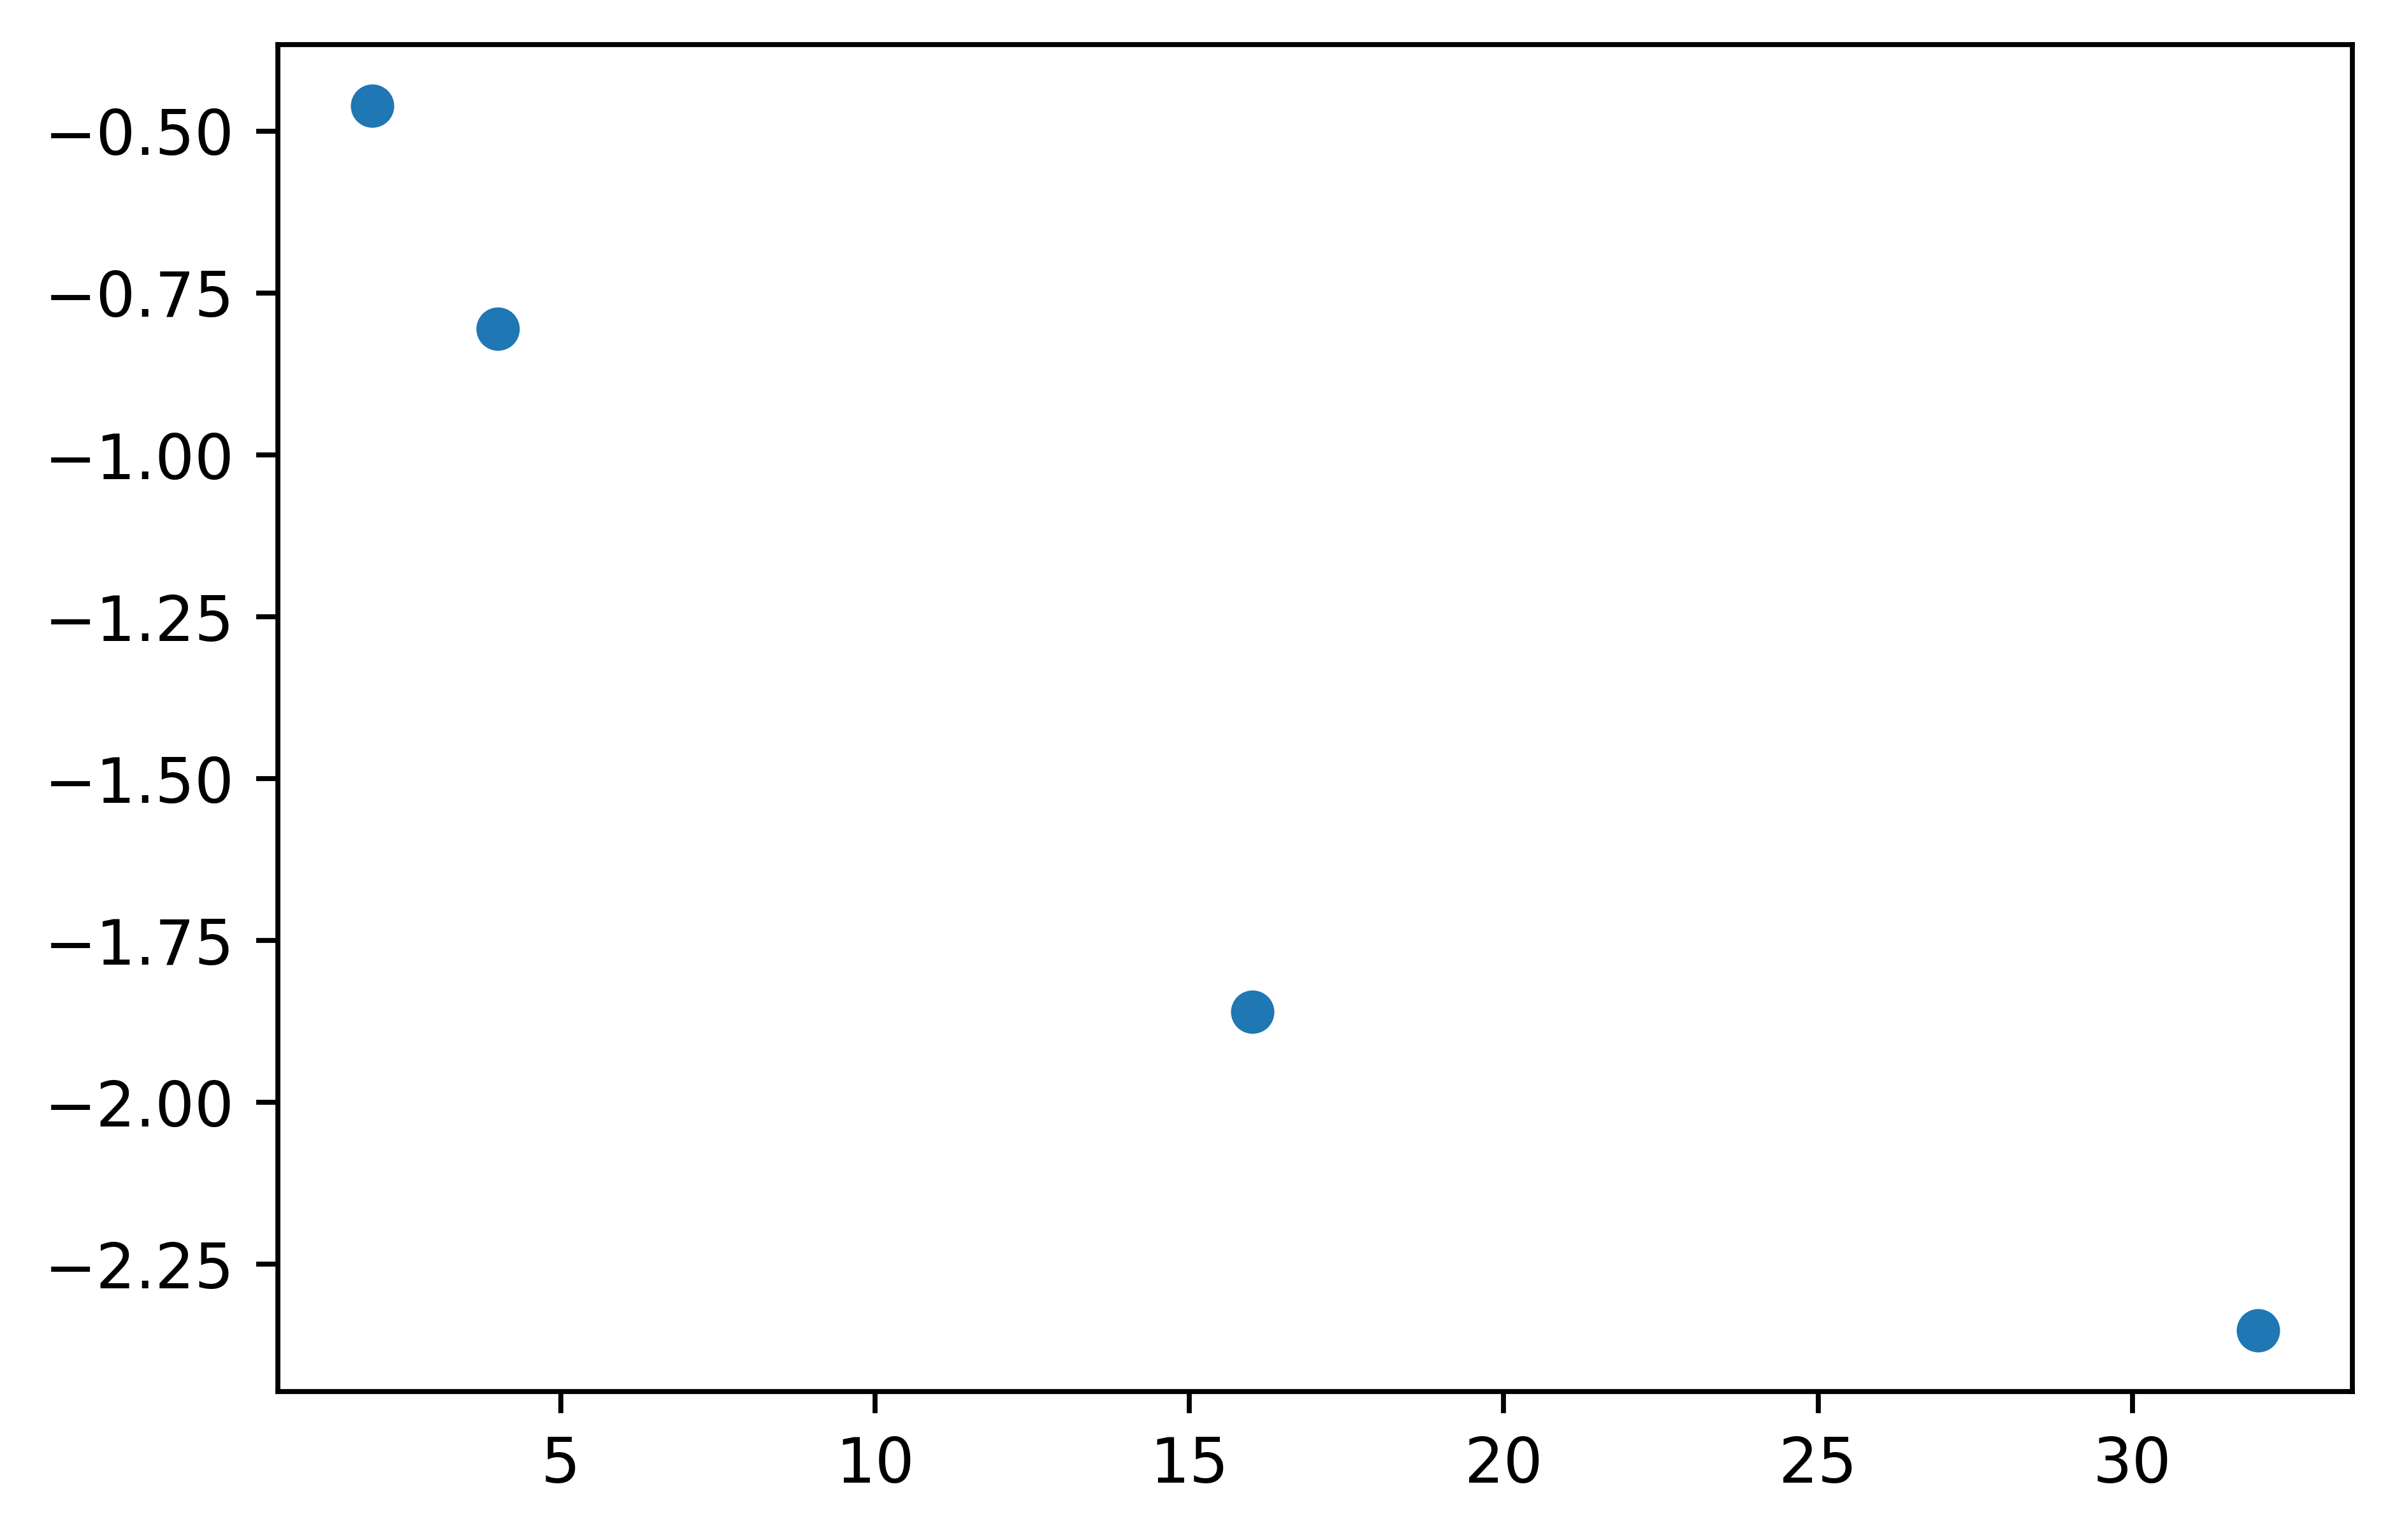

In [29]:
sizes = np.array([2, 4, 16, 32])
a_set = np.array([popt2x[0], popt4x[0], popt16x[0], popt32x[0]])
b_set = np.array([popt2x[1], popt4x[1], popt16x[1], popt32x[1]])
c_set = np.array([popt2x[2], popt4x[2], popt16x[2], popt32x[2]])

plt.plot(sizes, a_set, marker='o', ls='', label='a set')
# plt.plot(sizes, b_set, marker='o', ls='', label='b set')
# plt.plot(sizes, c_set, marker='o', ls='', label='c set')

## It looks like the a parameter might actually end up converging to something

In [37]:
a = -0.4166
alpha = 3.1e-4

l = 96*4
n = 513

S_val = 0.5
ctr = [[-32*4, 0], [32*4, 0]]
r = [1, 1]
m = [-1/2, 1/2]

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = np.ceil(-a*ctr[1][0]**2/dt * 8).astype(np.int)
comp_time = alpha*num_steps

print(comp_time)

60.1865


In [38]:
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

etaEuler = fd.makeForwardEuler(lch.etaEOM)
muEuler = fd.makeForwardEuler(lch.muEOM)
nuEuler = fd.makeForwardEuler(lch.nuEOM)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = etaEuler(eta_old, dt, mu_old, nu_old, dx, dy)
    mu_new = muEuler(mu_old, dt, eta_old, nu_old, dx, dy)
    nu_new = nuEuler(nu_old, dt, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= 2:
        peak_pos[:, i] = X[peaks]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=194150)

Simulation ran in 57.619817883333326 minutes.


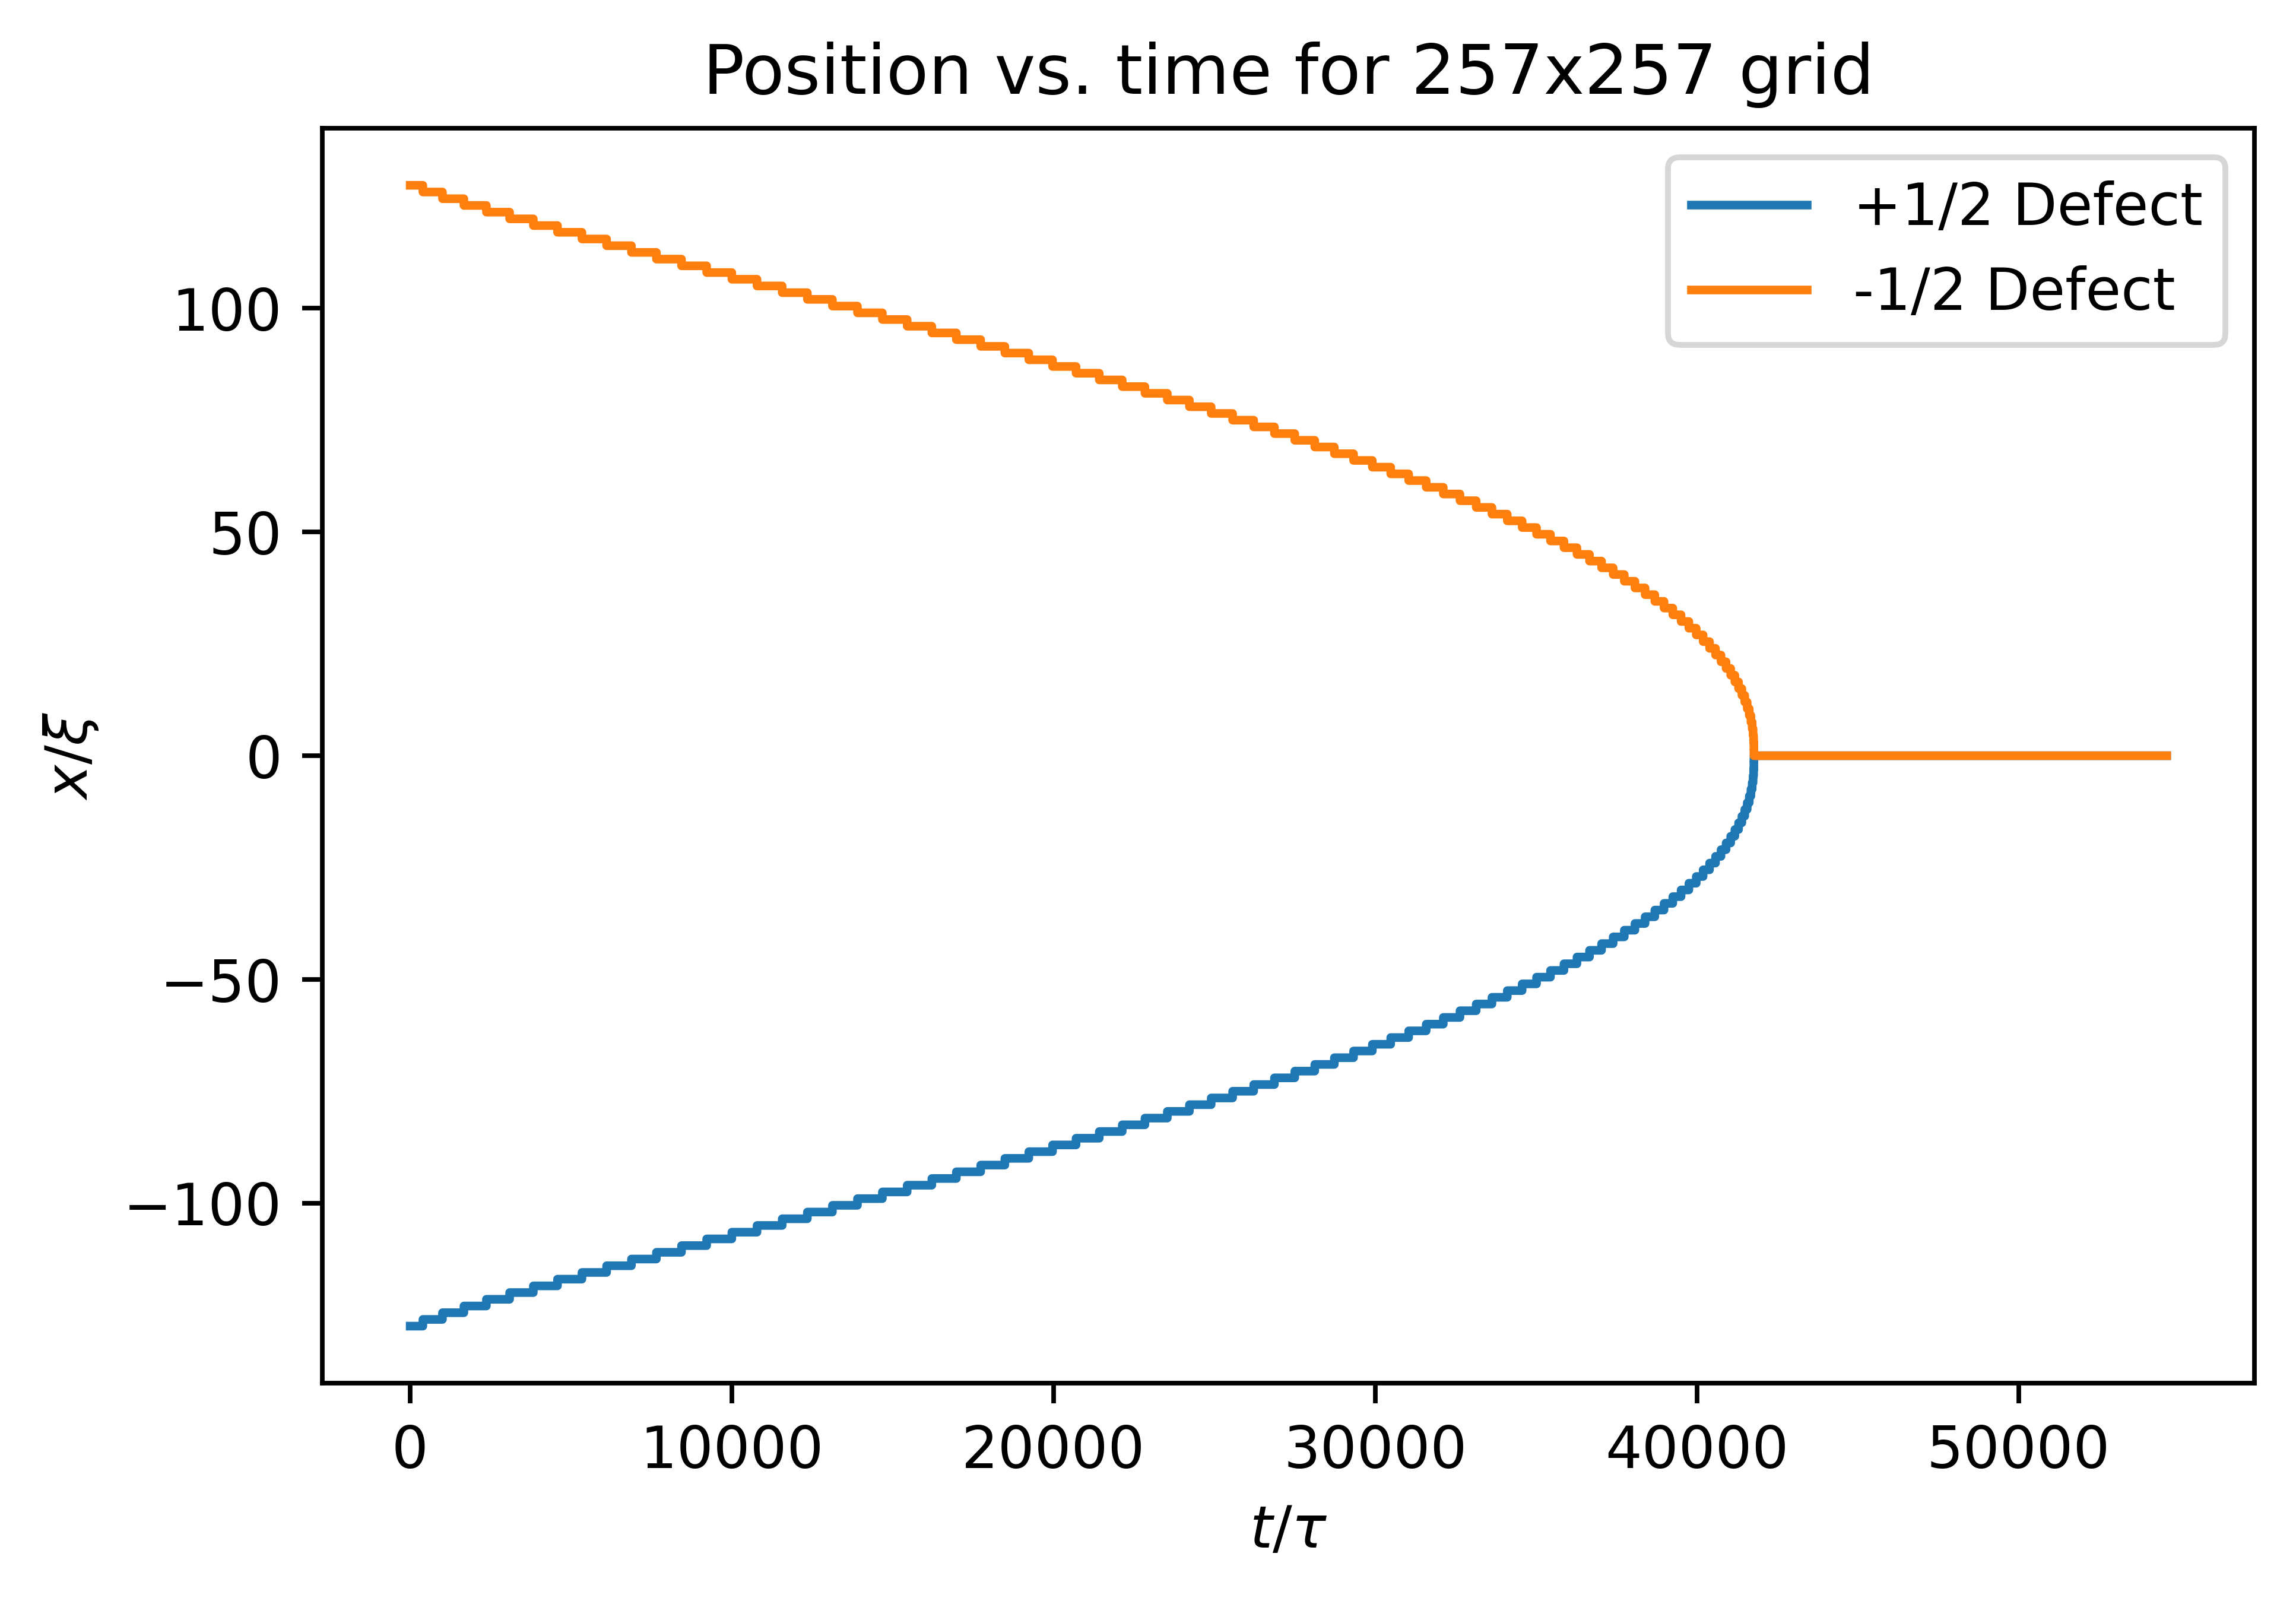

In [39]:
plt.plot(t[:], peak_pos[0, :], label='+1/2 Defect')
plt.plot(t[:], peak_pos[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 257x257 grid')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-257pts-64x-spacing.png')
plt.savefig(filename_defect_pos_vs_time)

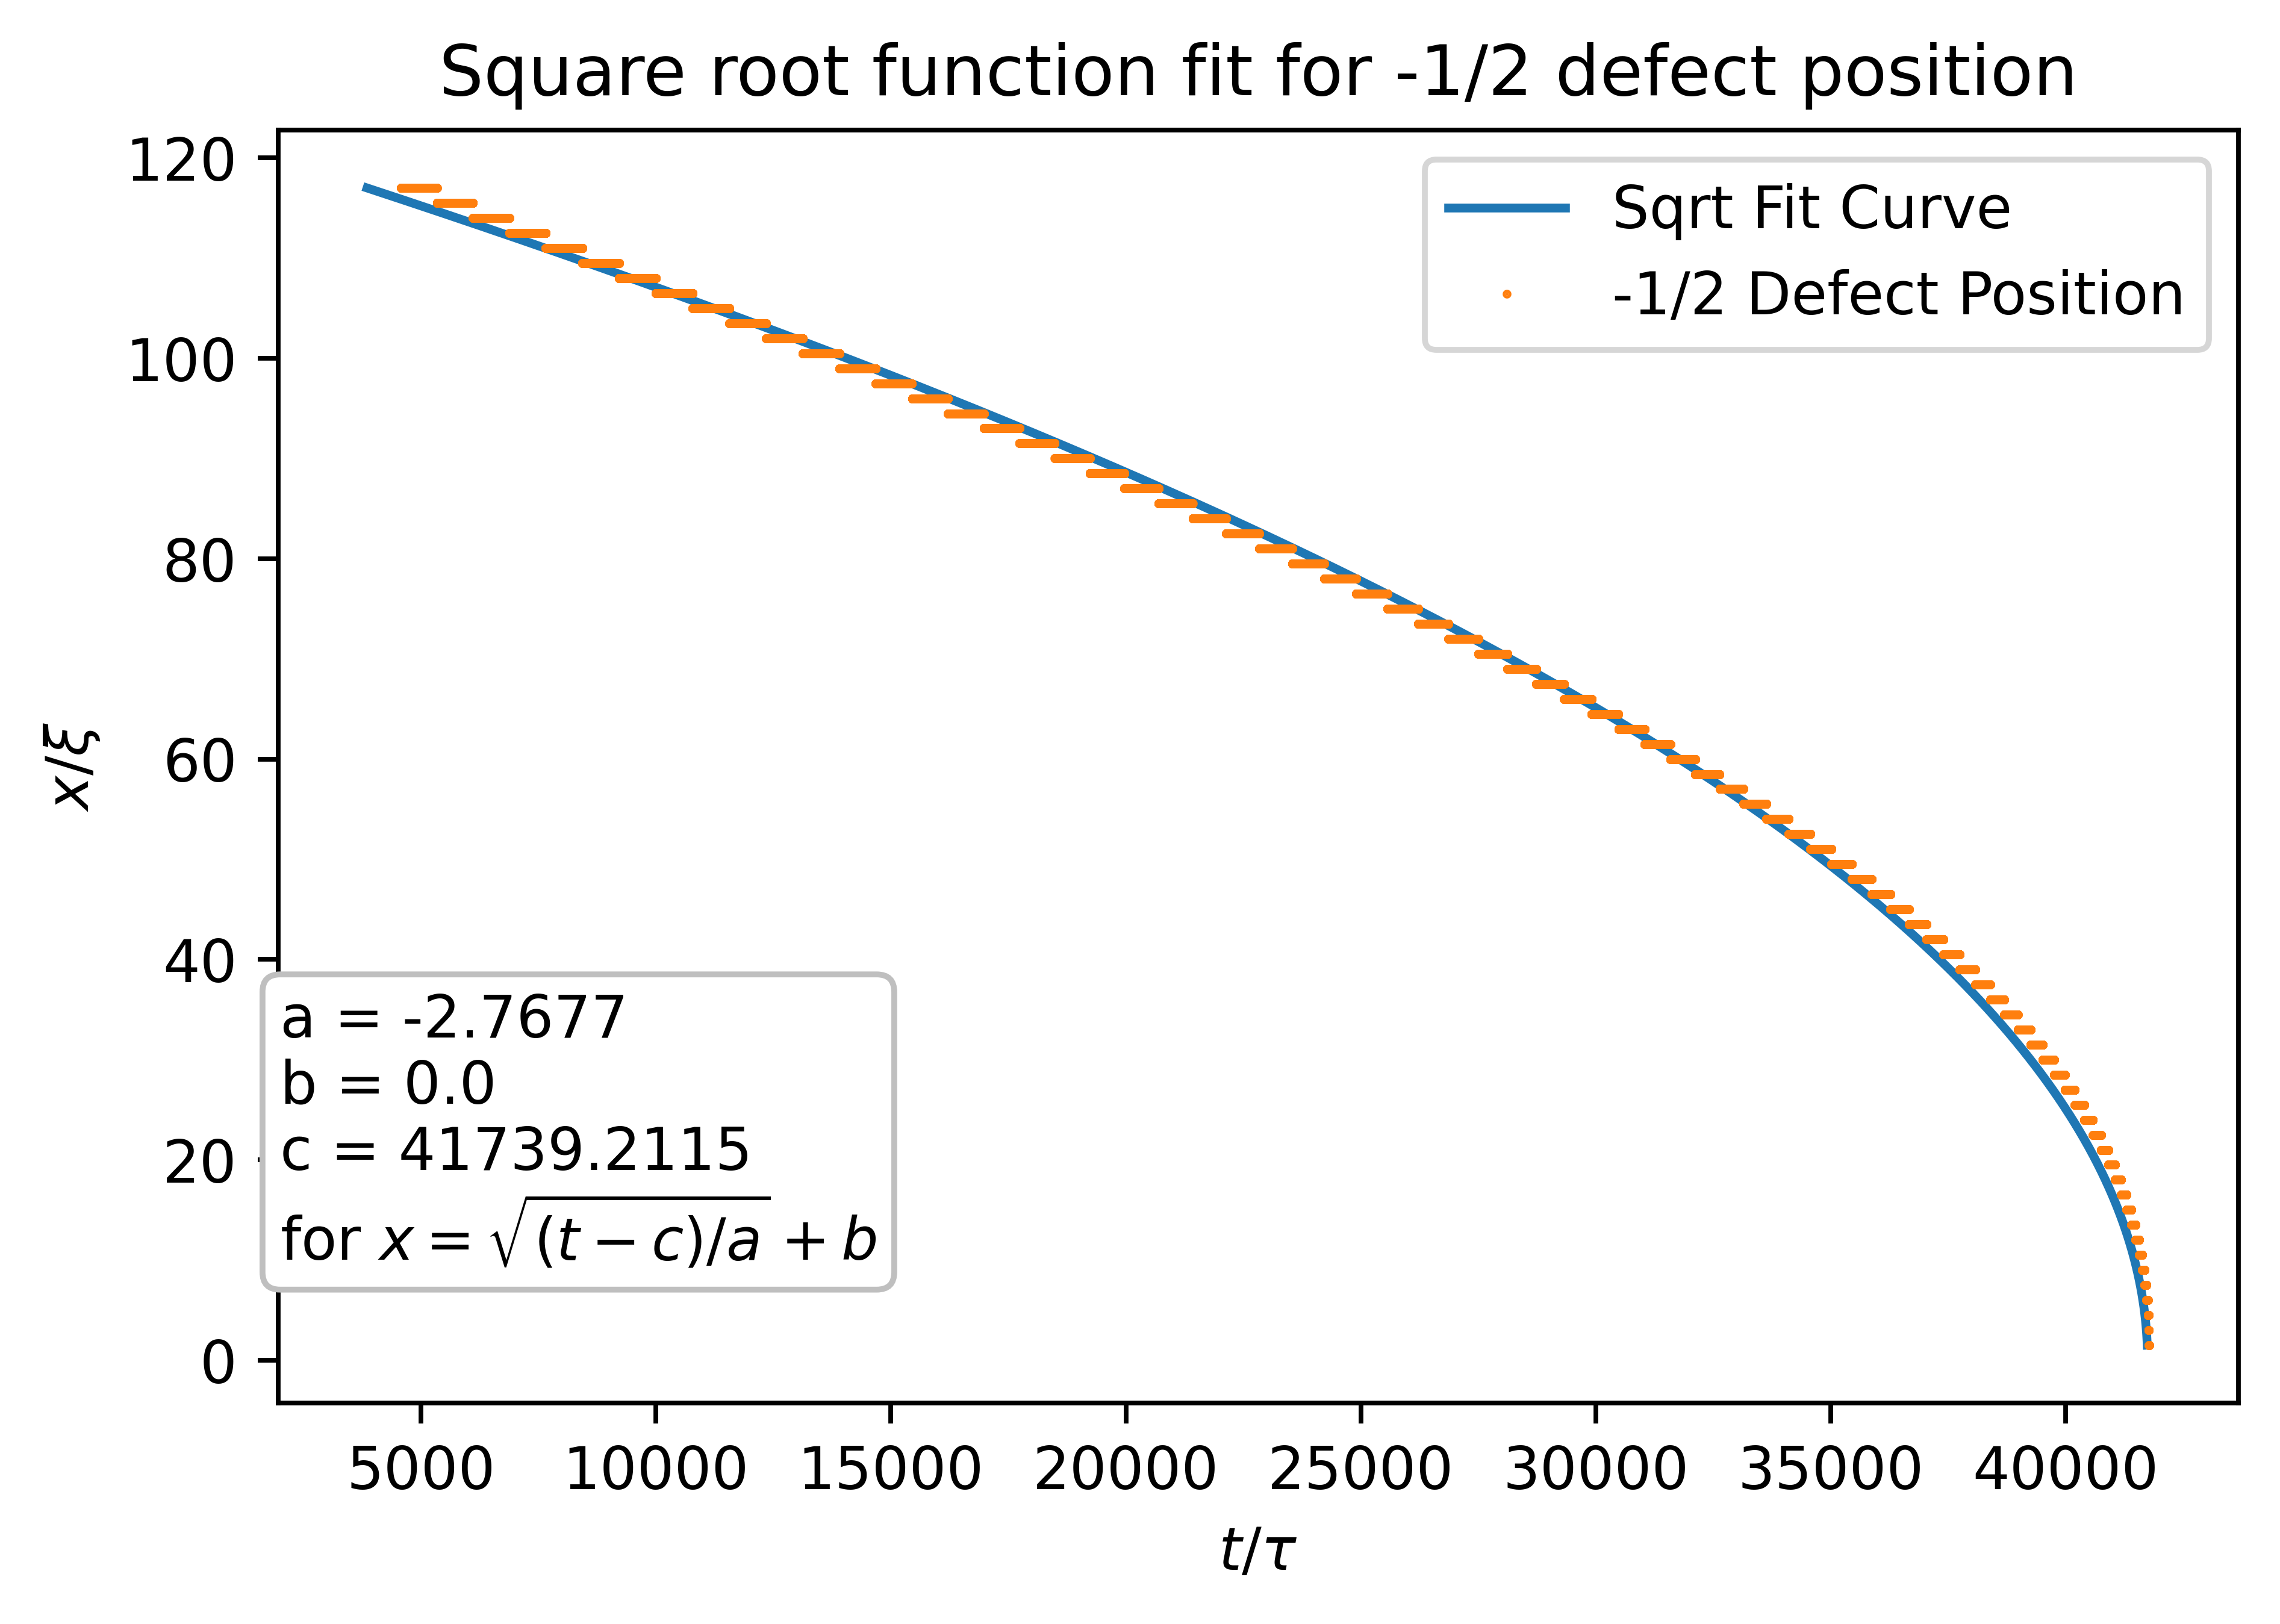

In [40]:
n_gridpoint_truncate = 6

# Truncate after defects meet, reflect over t-axis
defect_not_positive_idx = np.where(peak_pos[1, :] <= 0)[0]
first_not_positive_idx = defect_not_positive_idx[0]
trunc_pos = peak_pos[1, :first_not_positive_idx]
trunc_t = t[:first_not_positive_idx]

# lop off after n_gridpoint_truncate drop
start_idx = np.where(np.diff(trunc_pos))[0][n_gridpoint_truncate] + 1
trunc_pos = trunc_pos[start_idx:]
trunc_t = trunc_t[start_idx:]

trunc_pos_ref = np.hstack((trunc_pos, -trunc_pos[::-1]))
trunc_t_ref = np.hstack((trunc_t, trunc_t[::-1]))

# Find fit params
popt64x, pcov = curve_fit(f, trunc_pos_ref, trunc_t_ref)
a = popt64x[0]
b = popt64x[1]
c = popt64x[2]

# Plot results
fit_pos = np.linspace(trunc_pos[0], trunc_pos[-1], num=1000)
fit_t = f(fit_pos, a, b, c)
plot_text = ( "a = " + str(round(a, 4)) + "\n"
              + "b = " + str(round(b, 4)) + "\n"
              + "c = " + str(round(c, 4)) + "\n"
              + r"for $x = \sqrt{(t - c)/a} + b$" )

fig, ax = plt.subplots()
ax.plot(fit_t, fit_pos, label='Sqrt Fit Curve')
ax.plot(trunc_t, trunc_pos, marker='o', ls='', ms=.5, label='-1/2 Defect Position')
ax.text(2000, 10, plot_text,
        bbox=dict(boxstyle="round",
                  fc=(1, 1, 1),
                  ec=(.75, .75, .75)))
ax.legend()

ax.set_title('Square root function fit for -1/2 defect position')
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel(r'$x/\xi$')

filename_sqrt_fit = os.path.join(save_folder, r'sqrt-fit-257pts-64x-spacing.png')
fig.savefig(filename_sqrt_fit)

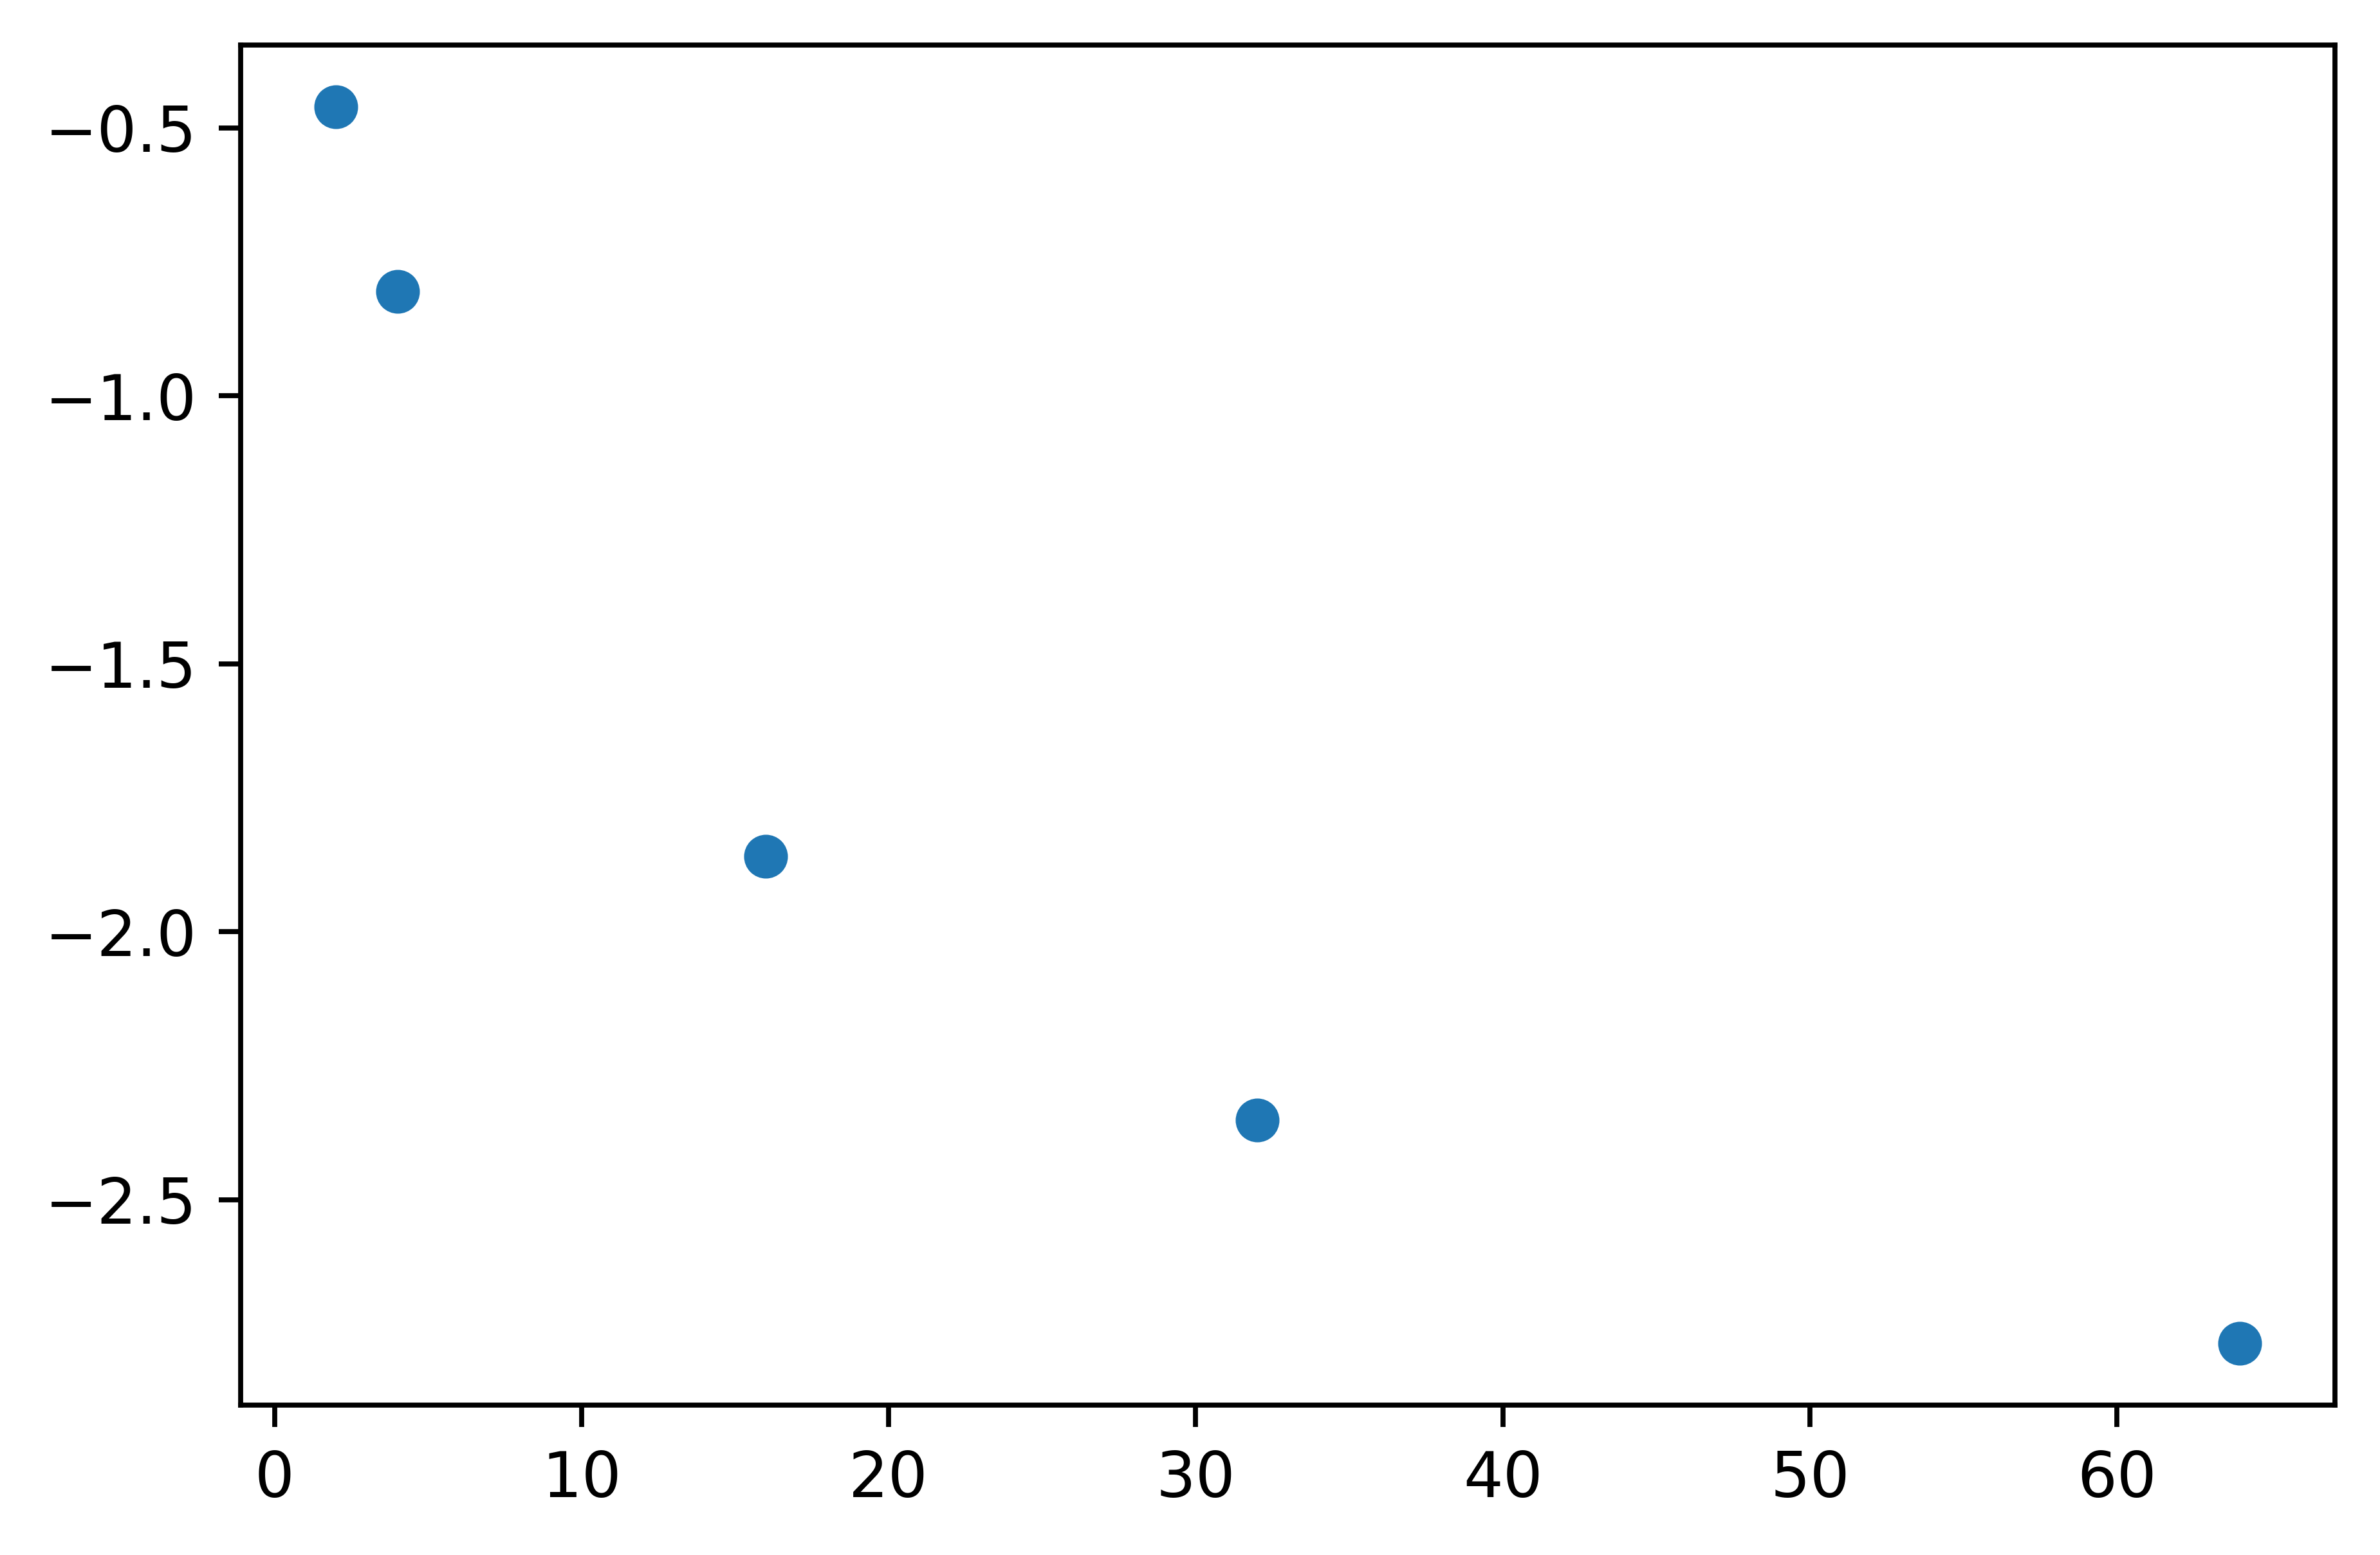

In [42]:
sizes = np.array([2, 4, 16, 32, 64])
a_set = np.array([popt2x[0], popt4x[0], popt16x[0], popt32x[0], popt64x[0]])
b_set = np.array([popt2x[1], popt4x[1], popt16x[1], popt32x[1], popt64x[1]])
c_set = np.array([popt2x[2], popt4x[2], popt16x[2], popt32x[2], popt64x[2]])

plt.plot(sizes, a_set, marker='o', ls='', label='a set')

## So then $a$ might converge to something around $-3$